# Setup

### Activate inline plotting

In [1]:
%pylab inline
import sys
sys.path.insert(0, '../modules')
import numpy as np
import math
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Plotting options
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif', size=15)

In [3]:
def get_image_directory(directory):
    """
    Store images in directory, make directory if need be
    """
    if not os.path.exists(directory):
        os.makedirs(directory)

def plot_2d_histogram(data, x_bins, y_bins, uselog=False,\
                      x_label="X Distribtuion", y_label="Y Distribution", z_label="Number of Events",\
                      title="", figsize_1=[12,10], filename="", dirname="", show_plot=True):
    """
    Function for plotting 
    """
    if title == "":
        title = z_label+" vs. "+x_label+" and "+y_label
    figsize(figsize_1[0],figsize_1[1])
    #data
    data = data.reshape((len(x_bins)-1,len(y_bins)-1))
    fig, ax = plt.subplots()
    if uselog :
        heatmap = ax.pcolor(data, norm=matplotlib.colors.LogNorm())
    else :
        heatmap = ax.pcolor(data)
        
    #legend
    cbar = plt.colorbar(heatmap)
    ticks = cbar.ax.get_yticks()
    if uselog :
        data = np.log10(data+1)
    heatmap = ax.pcolor(data)
    cbar.ax.set_yticks(ticks,fontsize=12)
    cbar.set_label(z_label, rotation=270, labelpad=20, fontsize=15)

    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(len(y_bins))[0::2], minor=False)
    ax.set_yticks(np.arange(len(x_bins)), minor=False)
    ax.set_ylabel(y_label, fontsize=15) 

    ax.set_xlabel(x_label, fontsize=15)
    ax.set_title(title, fontsize=15)

    #labels
    column_labels = x_bins[0::2].round(2)
    row_labels = y_bins.round(2)
    ax.set_xticklabels(column_labels, minor=False,fontsize=12)
    ax.set_yticklabels(row_labels, minor=False,fontsize=12)
    
    if (filename != "") & (dirname != ""): 
        get_image_directory(dirname)
        savefig(dirname+"/"+filename)
    
def plot_1d_histogram(data, x_bins, uselog=False,\
                      x_label="X Distribtuion", y_label="Number of Events",\
                      title="", figsize_1=[12,10], filename="", dirname="",off_set_x_axis=0,
                      show_plot=True):
    """
    Function for plotting 1d histograms
    """
    figsize(figsize_1[0],figsize_1[1])
    if title == "":
        title = y_label+" vs "+x_label
        
    fig, ax = plt.subplots()
    
    #colors = ["green","red","blue"]
    ax.bar(x_bins, data, width=abs(x_bins[0]-x_bins[1]),color="Green")
    ax.set_title(title)
        
    # put the major ticks
    ax.set_xlabel(x_label, fontsize=15)
    ax.set_ylabel(y_label, fontsize=15)
    ax.set_title(title, fontsize=15)

    #Adjust x-axis for binning
    if off_set_x_axis != 0:     
        column_labels = x_bins
        ax.set_xticks(x_bins, minor=False)
        ax.set_xticks(np.arange(len(x_bins))[0::2]+off_set_x_axis, minor=False)
        ax.set_xticklabels(column_labels, minor=False,fontsize=12)
    
    if (filename != "") & (dirname != ""): 
        get_image_directory(dirname)
        savefig(dirname+"/"+filename)
    if show_plot:
        plt.show()

### Import Dataset(s)

In [4]:
from root_numpy import root2array
from data import AlCapROOT
import pandas as pd
from collections import OrderedDict, namedtuple

In [5]:
# List the relevant output files
momentums = ['28','30','32','34','36','38','40']
#momentums = ['28','40']

# Define the group of histograms, with first row as the bin_centers
volumes = ["Mylar_Window", "Target", "PreTargAlSh","PreTargPaSh", "PreTarg", "Target_Back"]

# Define particle names
part_name = ["muons","pions"]

n_catogories = len(volumes)*len(part_name)*len(momentums)

# Put this output somewhere
geometry_name = "geom_June_7"
geom_dir = "/home/elg112/ALCAP/PAlCap/images/"+geometry_name+"/"
data_dir = "/home/elg112/ALCAP/PAlCap/data/"+geometry_name+"/"


In [6]:
analysis_bins = 20

#Book the histogram
dist_histos = []
stop_z_dist = []
stop_histos = []
# Construct a named tuple so it is easy to keep track of which histogram are saving
Histogram = namedtuple('Histogram', ['particle', 'volume', 'momentum', 'data', 'bin_edges'])

for pid in part_name:
    for mom_id, momentum in enumerate(momentums):
        ## Initialize the numpy array
        print "Processing " + momentum + " MeV/c data"
        # Choose the file path and branches that will be loaded
        file_path = data_dir+pid+'_'+momentum+'MeV_10e5.root'
        tree_branches = ['M_tid','M_stopped', 'M_volName','M_x','M_y','M_Oz']
        # Load the root file
        particles = AlCapROOT(path=file_path, branches=tree_branches)
        
        # Uncomment to check all volumes availible
        #print set(particle.hits_data["M_volName"])
    
        # Get all the original particle from beam
        muon_hits = np.where(particles.hits_data["M_tid"] == 1)[0]
        # Get the stopped hits
        stop_hits = np.where(particles.hits_data[muon_hits]["M_stopped"] == 1)
        # Revert this back to sample wide hit IDs
        muon_stop_hits = muon_hits[stop_hits]
        
        for vol_id, volume in enumerate(volumes):
            
            ############ BEAM PROFILE AS IT PASSES THE VOLUME OF INTEREST ###########   
            print "   Getting xy distribution in "+volume
            # Get the hits in the current volume
            vol_hits = np.where(particles.hits_data[muon_hits]["M_volName"] == volume)

            # Revert this back to sample wide hit IDs
            muon_vol_hits = muon_hits[vol_hits]

            # Check there will be some hits in these before we save them
            if len(muon_vol_hits) == 0:
                print "   ### No hits in "+volume+" at momentum "+momentum+"MeV/c ###" 
            else :
                # Get the histogram information from the needed hits and branches
                data, bin_edges = particles.get_histogram_2d(muon_vol_hits, bins=analysis_bins)
                histo_tuple = pid, volume, momentum, data, bin_edges

                # Save this information via defined histogram named tuple
                dist_histos.append(Histogram._make(histo_tuple))
            
            ##################### STOPPING DISTANCE AND PROFILE #####################   
            print "   Getting stopping distribution in "+volume

            # Get the volumes in those hits
            stop_vol_hits = np.where(particles.hits_data[muon_stop_hits]["M_volName"] == volume)

            # Revert this back to sample wide hit IDs
            muon_vol_stops = muon_stop_hits[stop_vol_hits]

            # Check there will be some hits in these before we save them
            if len(muon_vol_stops) == 0:
                print "   ## No stops in "+volume+" at momentum "+momentum+" MeV/c ##" 
            else :
                # Get the histogram information from the needed hits and branches
                data, bin_edges = particles.get_histogram_2d(muon_vol_stops, bins=analysis_bins) 
                histo_tuple = pid, volume, momentum, data, bin_edges
                stop_histos.append(Histogram._make(histo_tuple))

                # Get the histogram information from the needed hits and branches
                data, bin_edges = particles.get_histogram_1d(muon_vol_stops, x_axis="M_Oz") 
                histo_tuple = pid, volume, momentum, data, bin_edges
                stop_z_dist.append(Histogram._make(histo_tuple))

Processing 28 MeV/c data
   Getting xy distribution in Mylar_Window
   Getting stopping distribution in Mylar_Window
   ## No stops in Mylar_Window at momentum 28 MeV/c ##
   Getting xy distribution in Target
   Getting stopping distribution in Target
   Getting xy distribution in PreTargAlSh
   Getting stopping distribution in PreTargAlSh
   Getting xy distribution in PreTargPaSh
   ### No hits in PreTargPaSh at momentum 28MeV/c ###
   Getting stopping distribution in PreTargPaSh
   ## No stops in PreTargPaSh at momentum 28 MeV/c ##
   Getting xy distribution in PreTarg
   Getting stopping distribution in PreTarg
   Getting xy distribution in Target_Back
   ### No hits in Target_Back at momentum 28MeV/c ###
   Getting stopping distribution in Target_Back
   ## No stops in Target_Back at momentum 28 MeV/c ##
Processing 30 MeV/c data
   Getting xy distribution in Mylar_Window
   Getting stopping distribution in Mylar_Window
   ## No stops in Mylar_Window at momentum 30 MeV/c ##
   Getti

##Profile Histograms

/home/elg112/.local/lib/python2.7/site-packages/matplotlib/colorbar.py:215: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")
/home/elg112/.local/lib/python2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


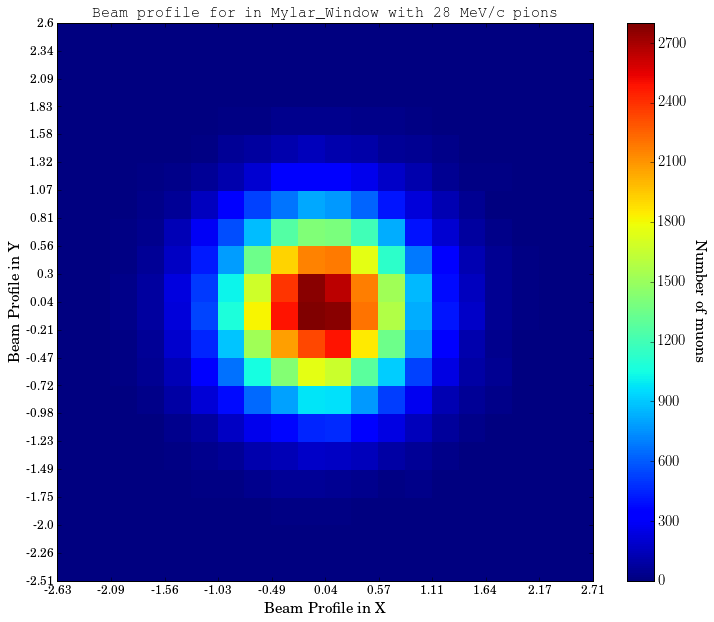

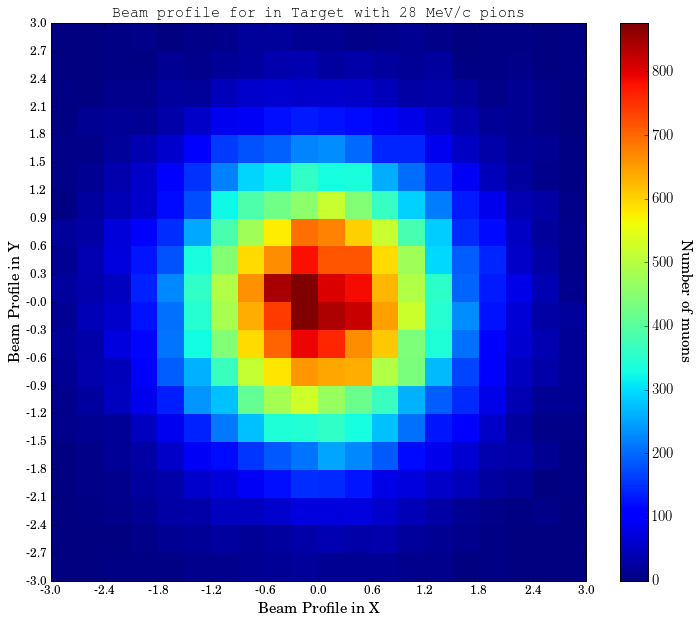

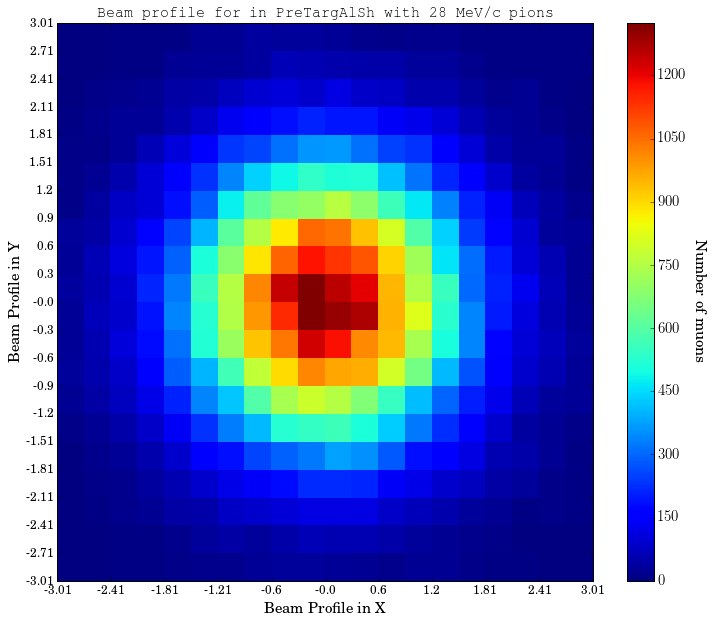

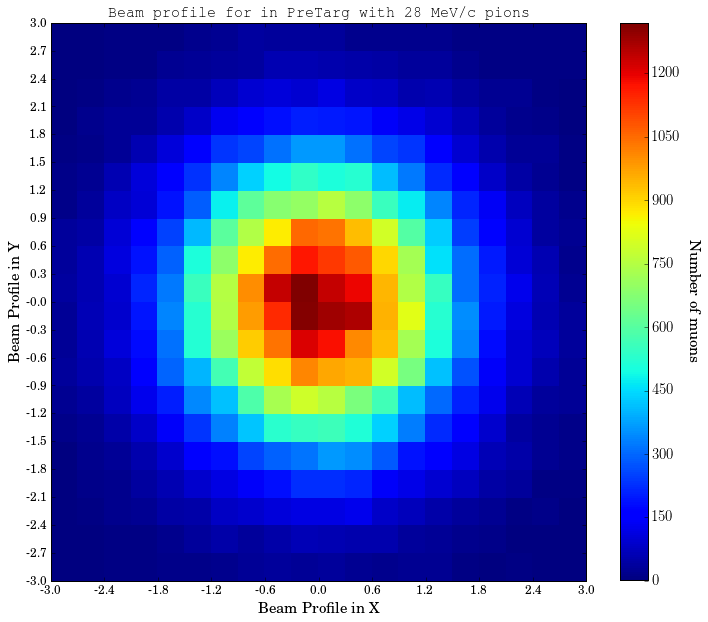

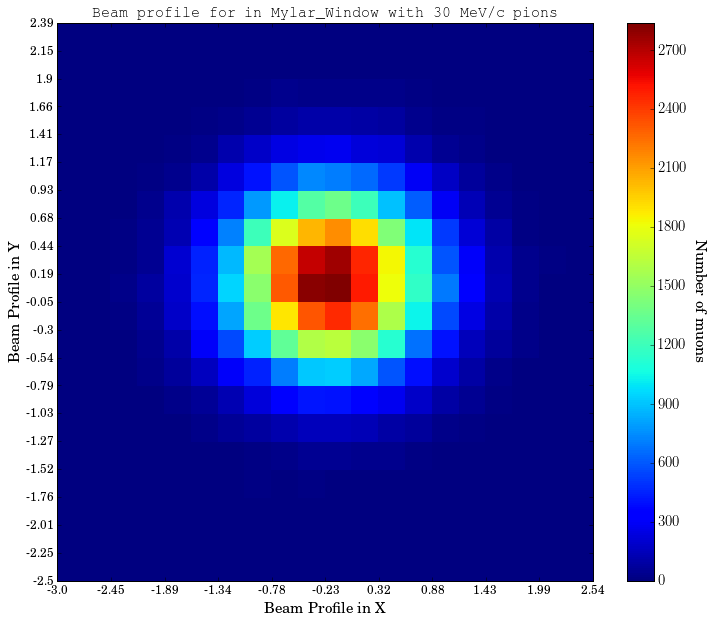

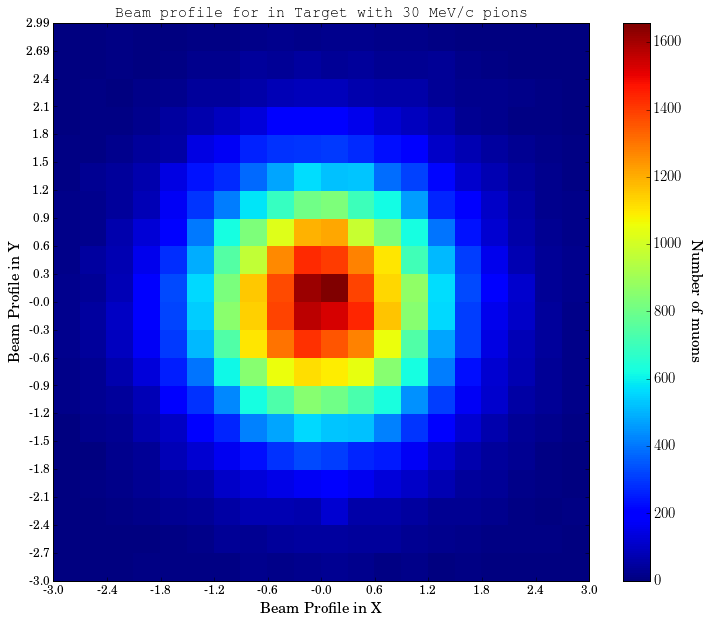

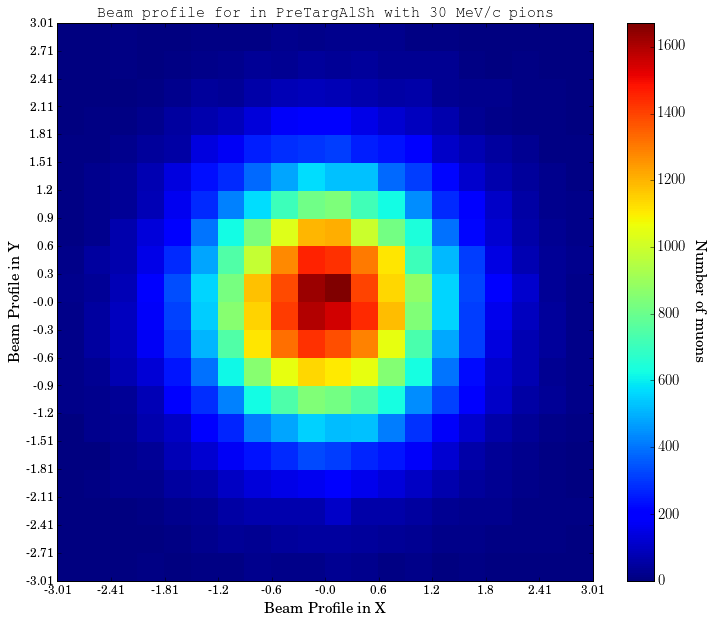

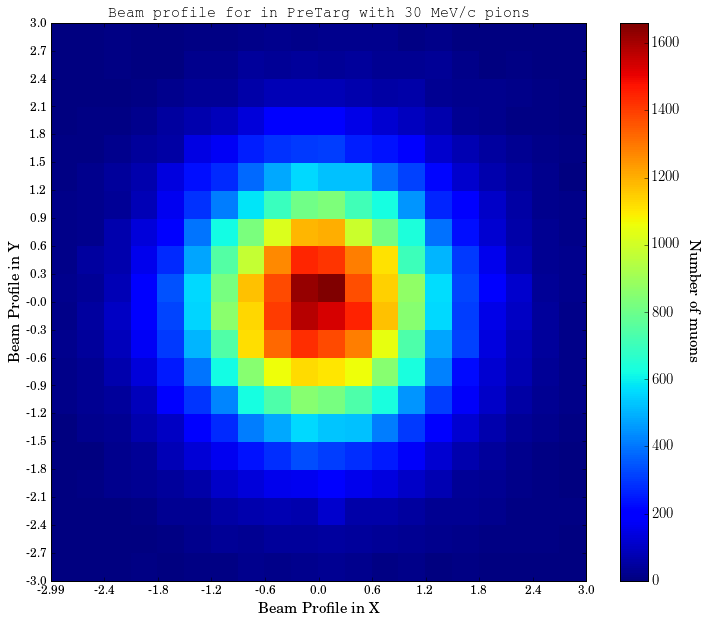

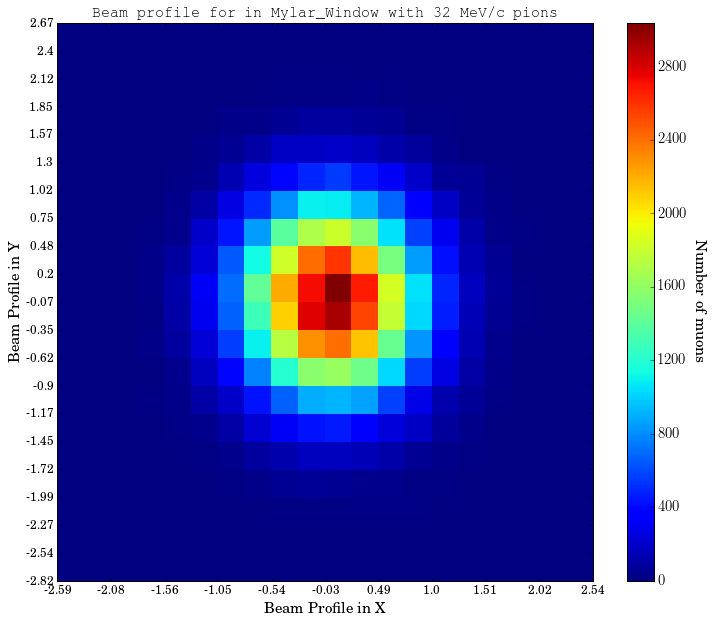

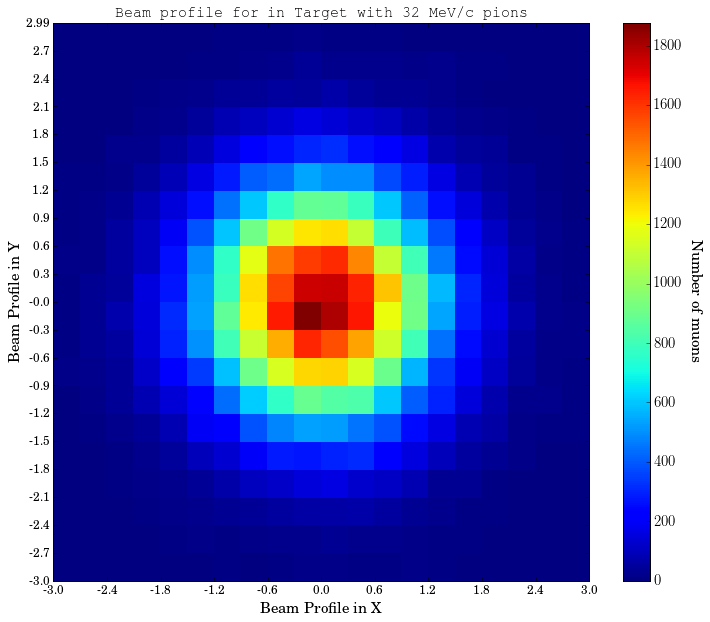

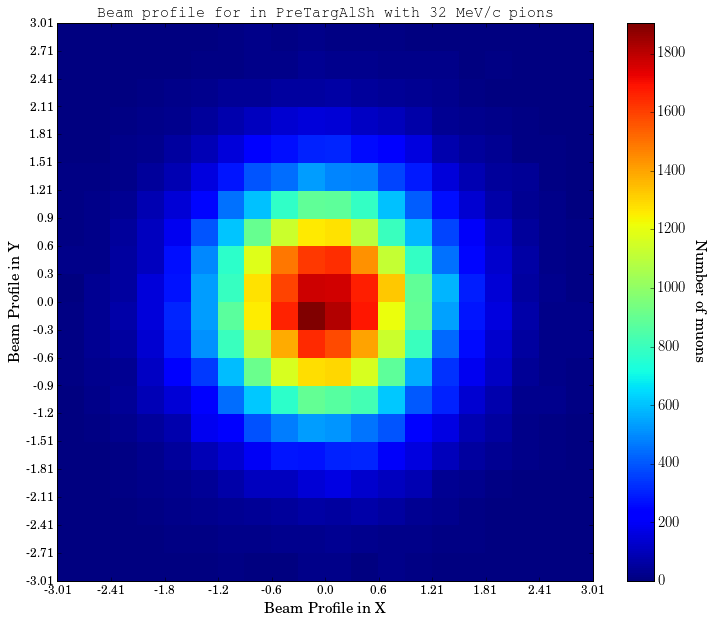

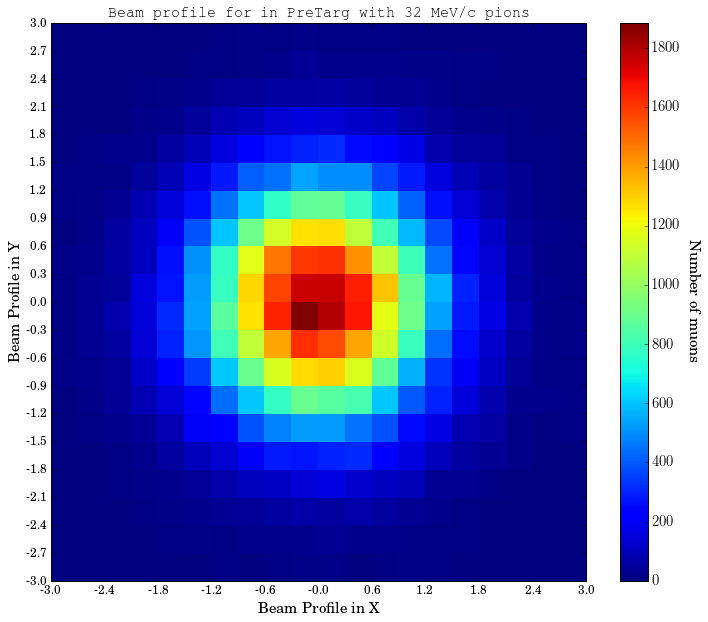

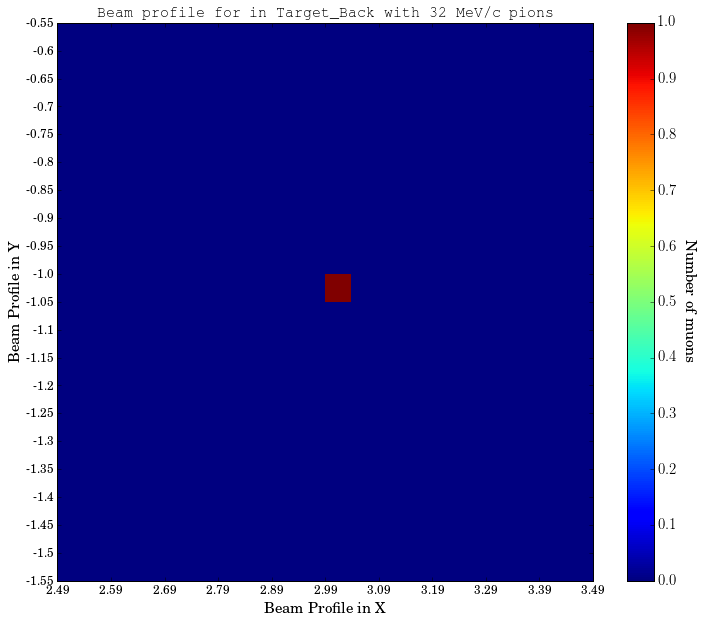

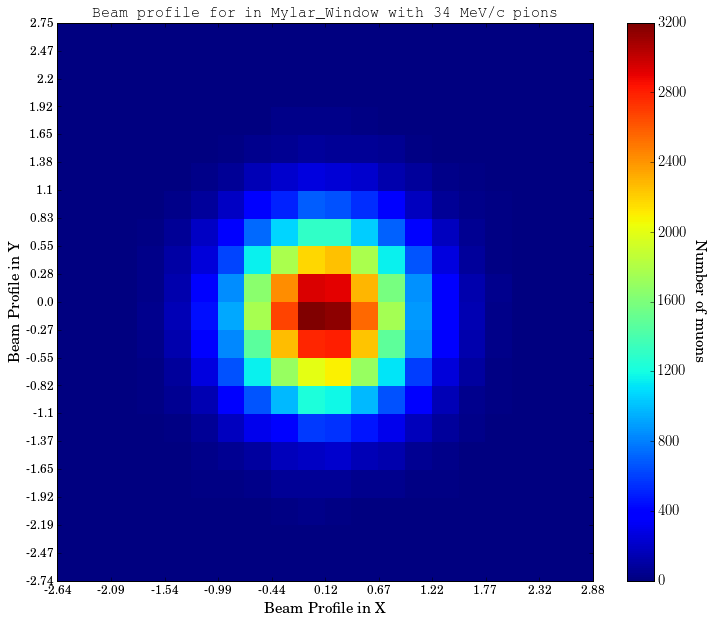

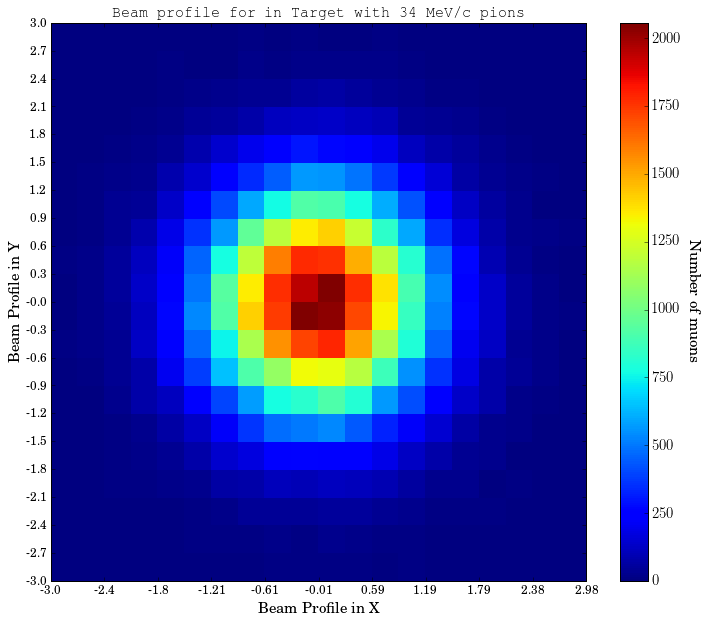

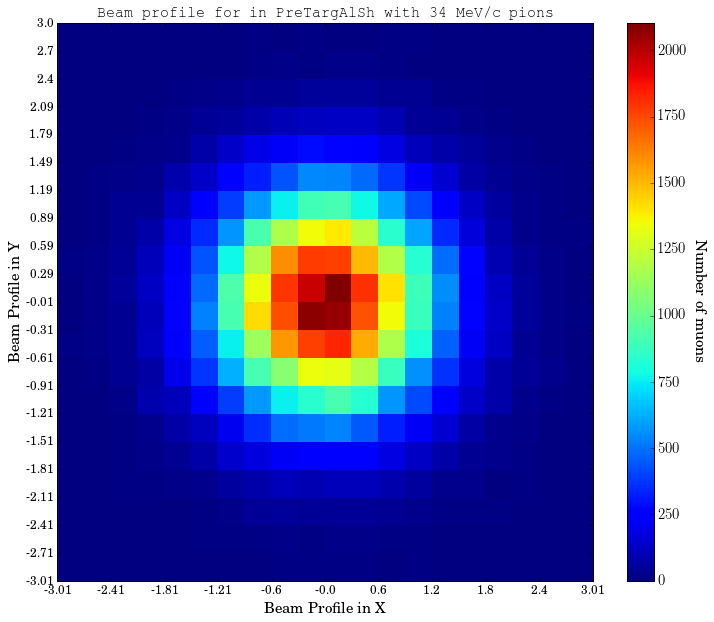

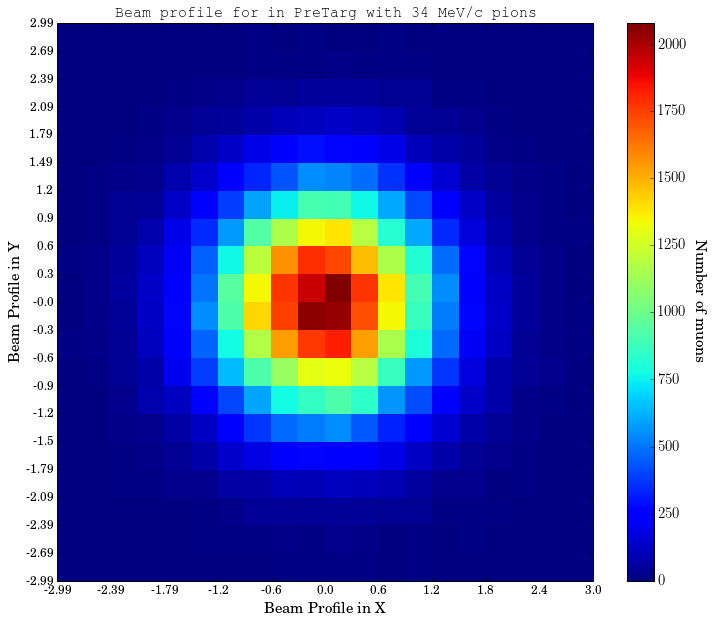

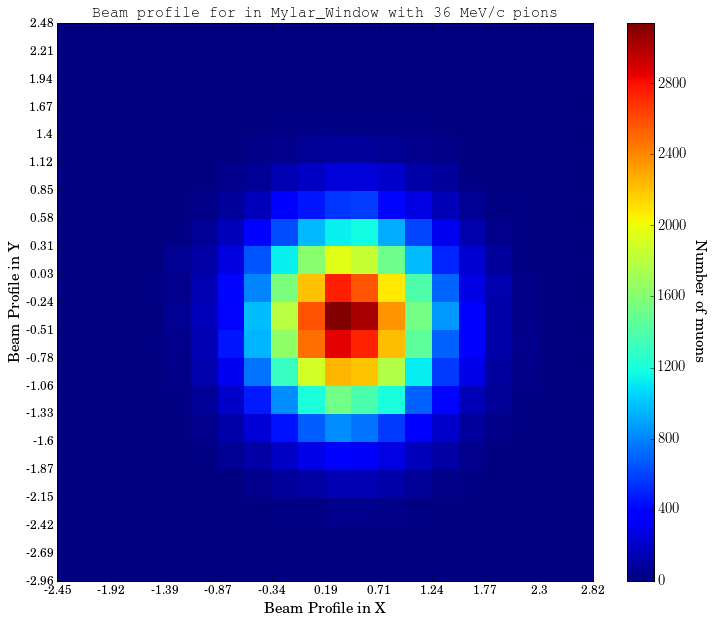

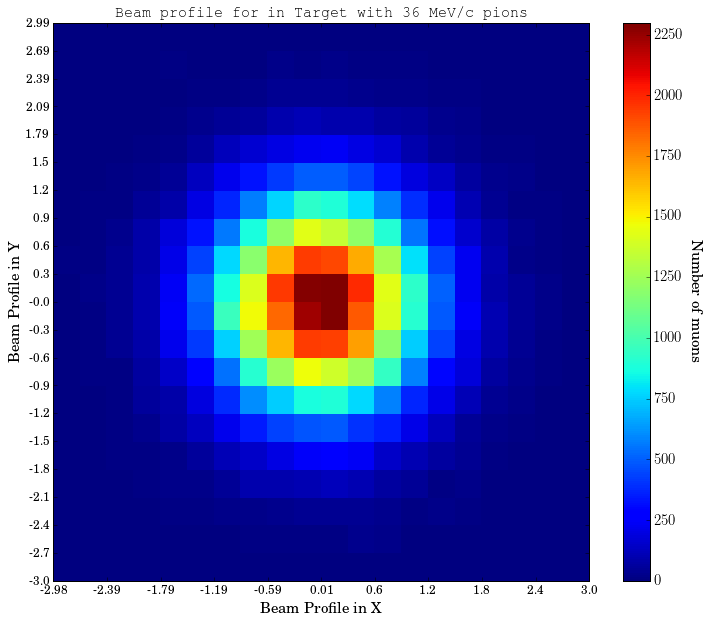

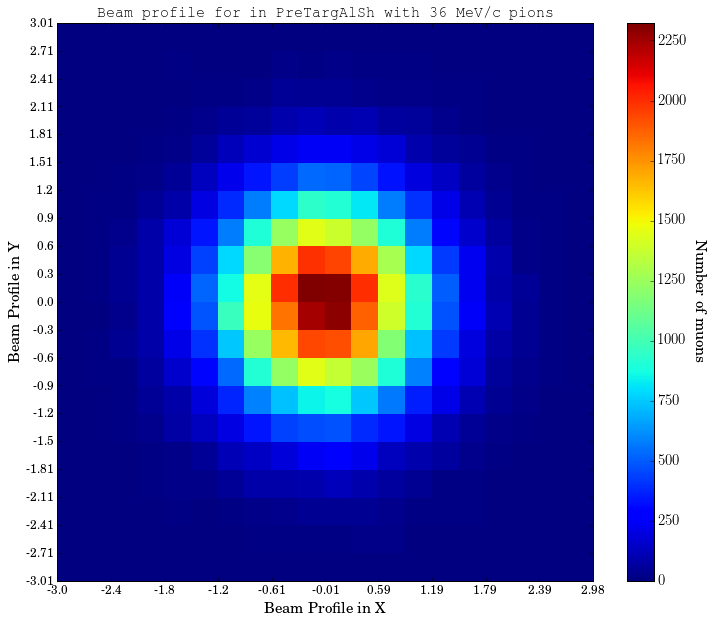

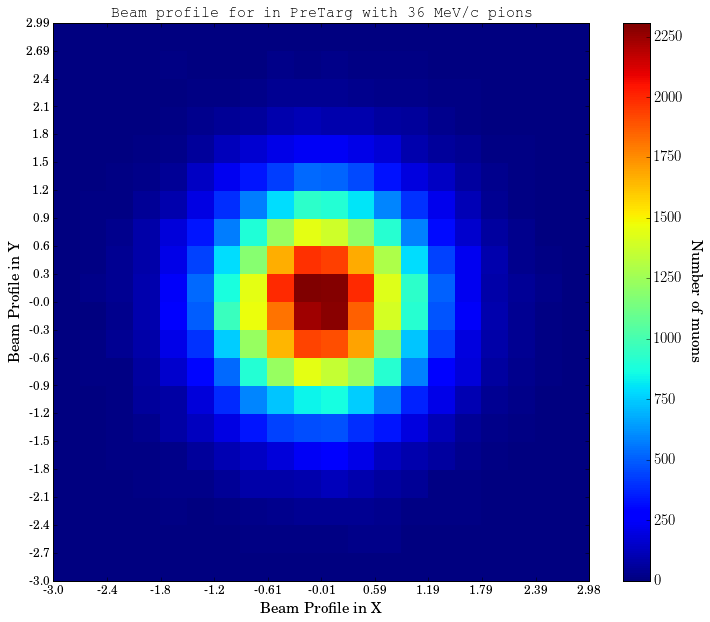

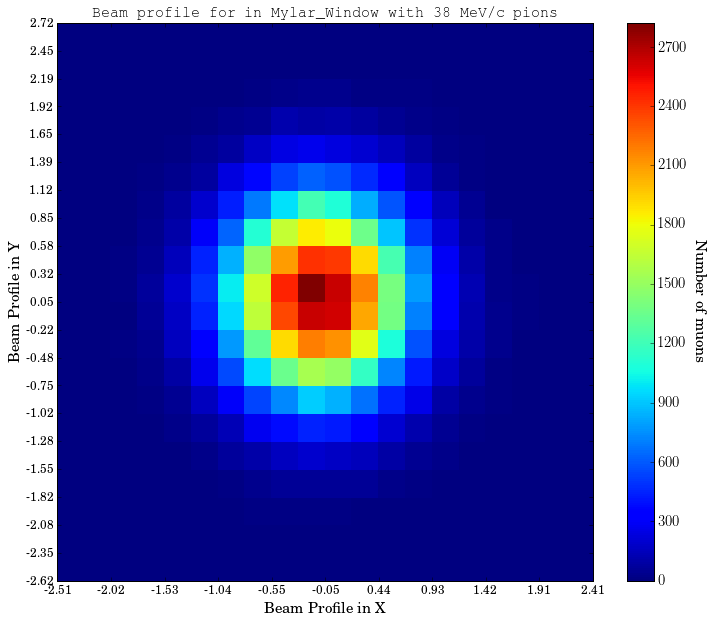

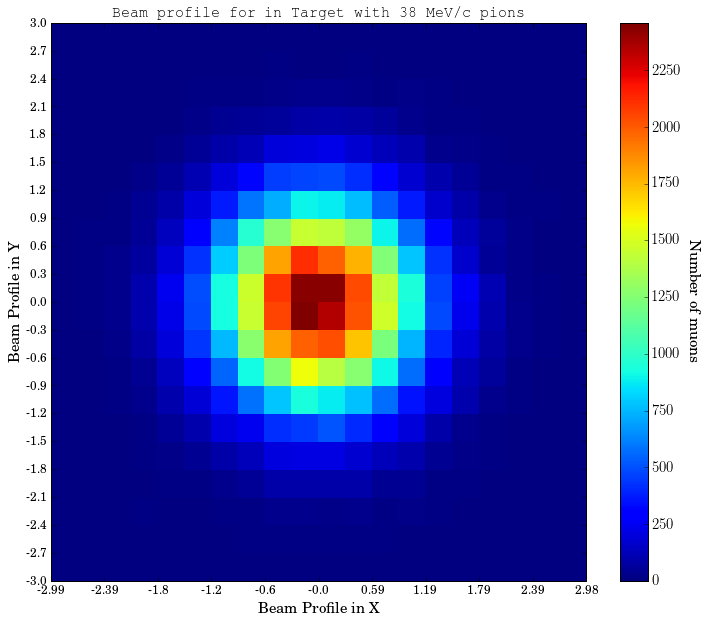

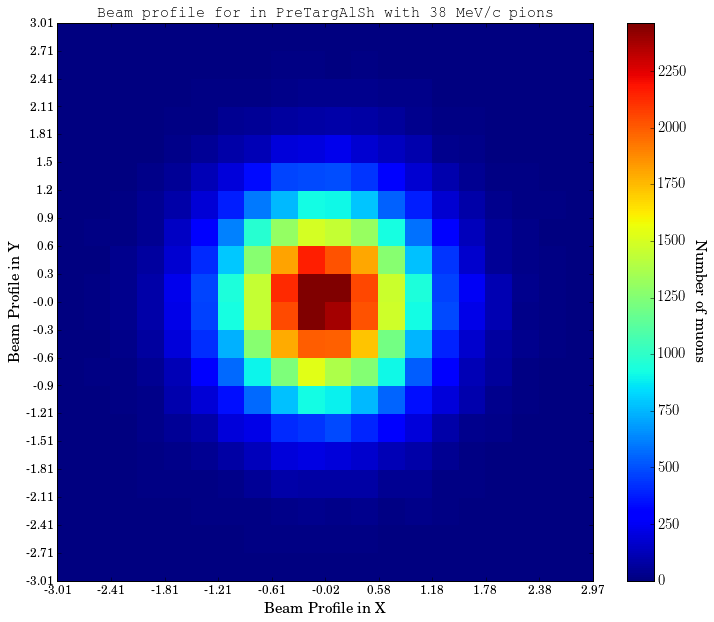

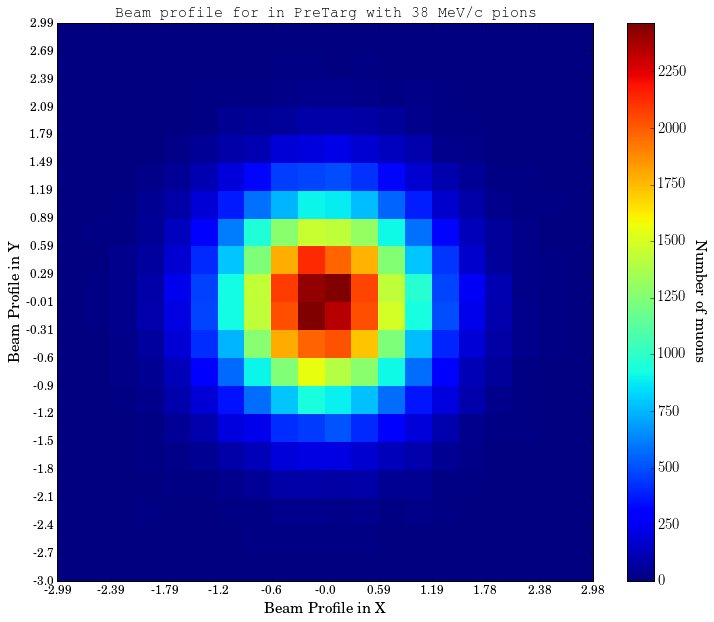

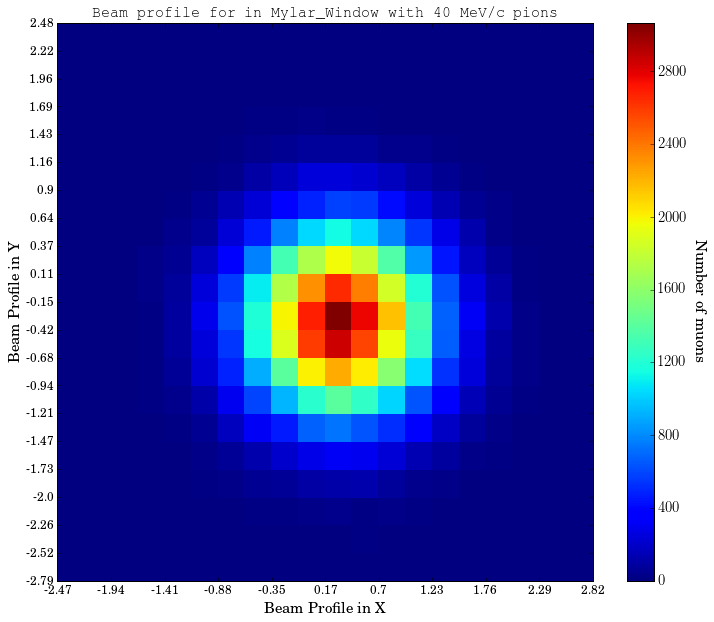

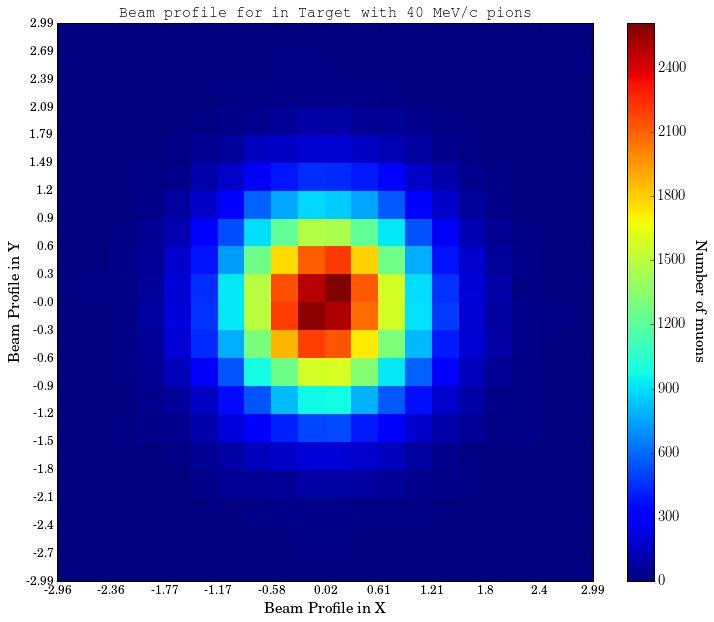

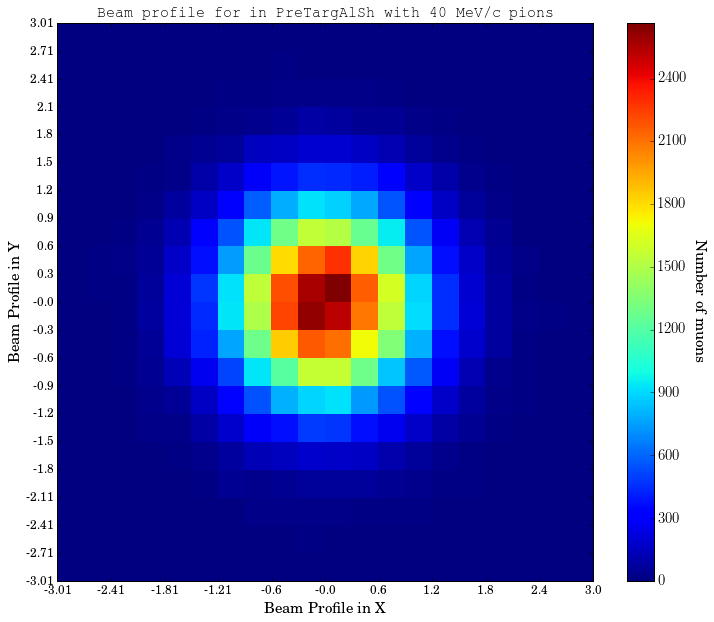

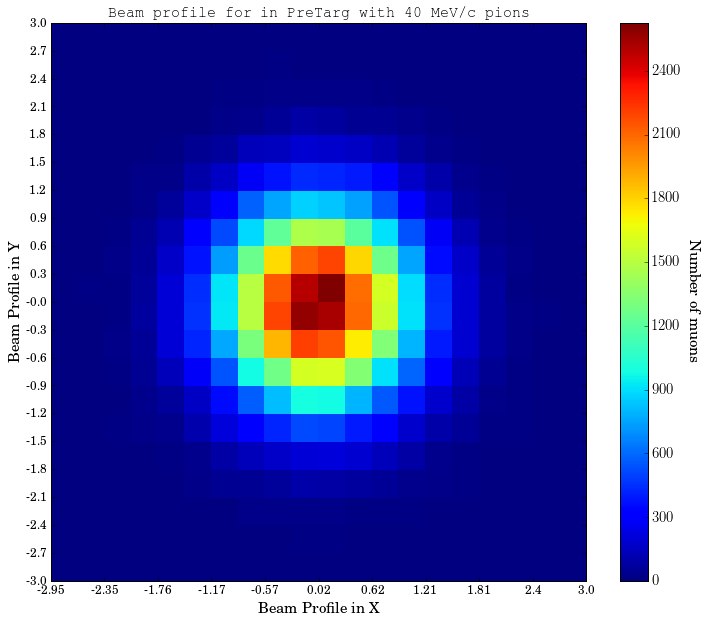

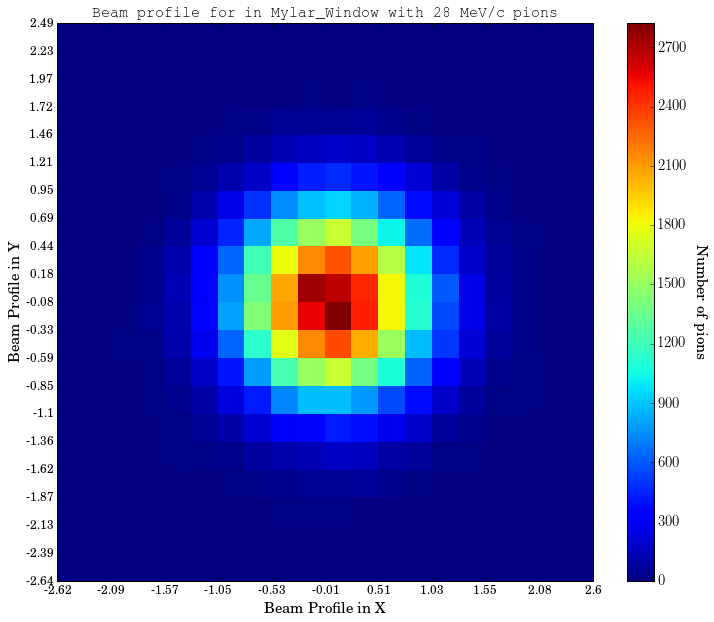

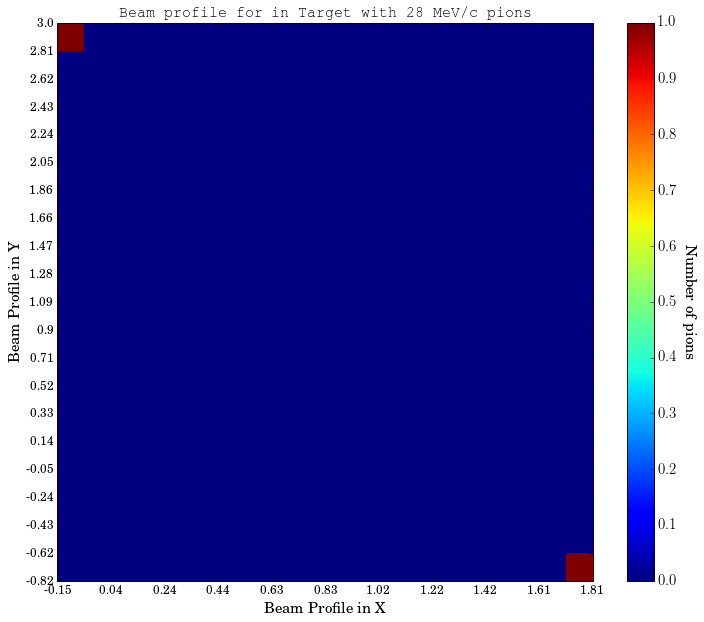

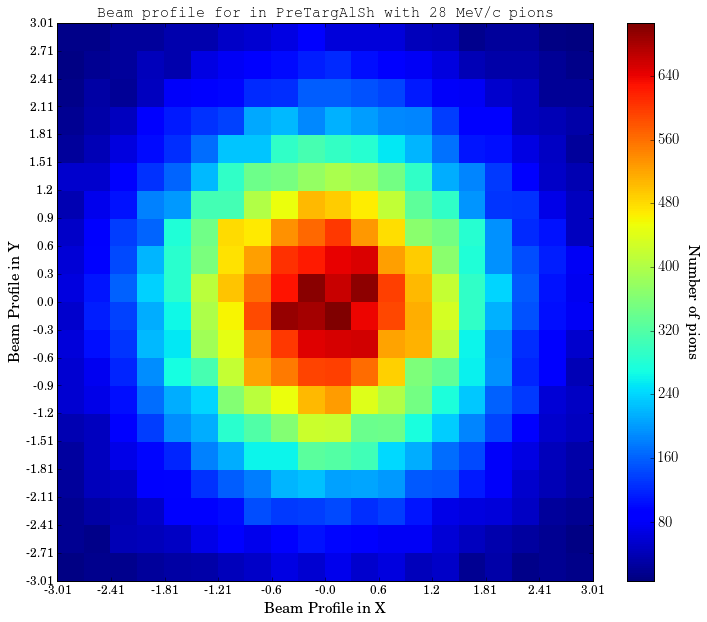

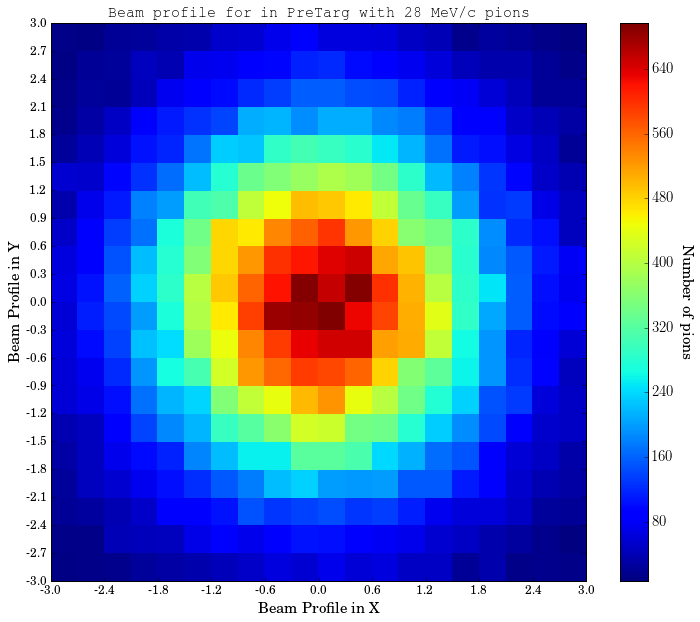

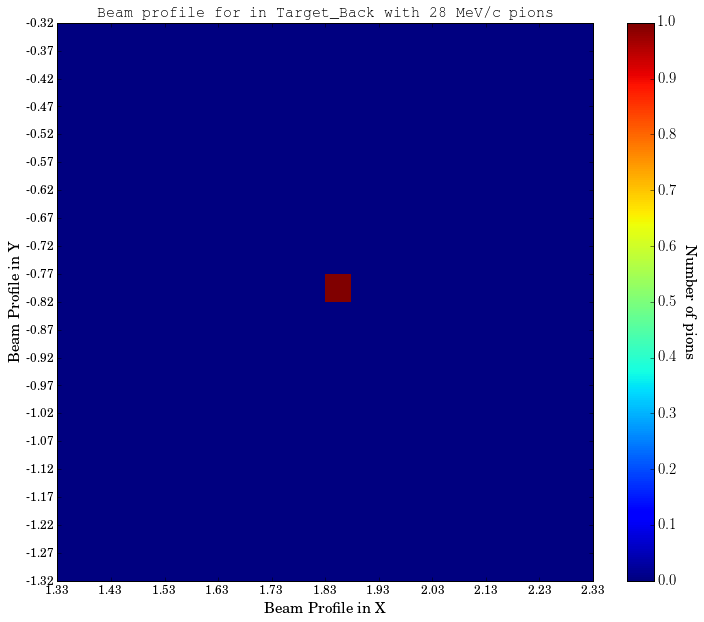

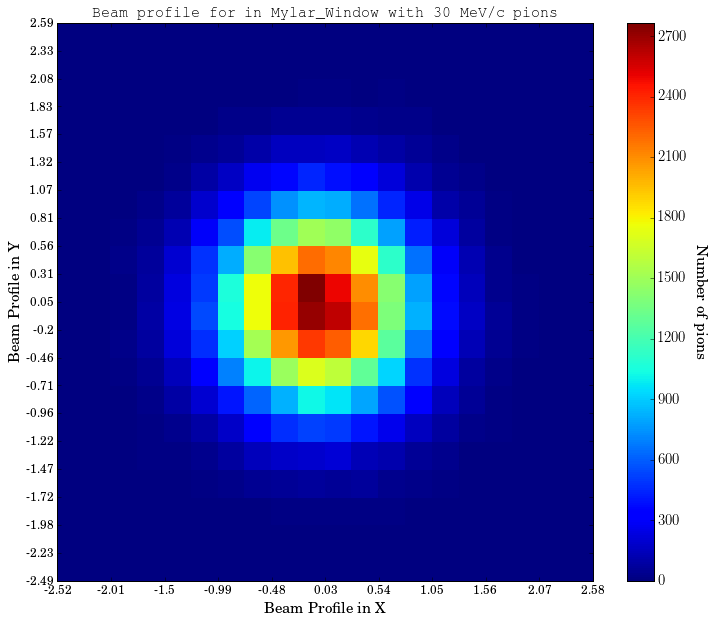

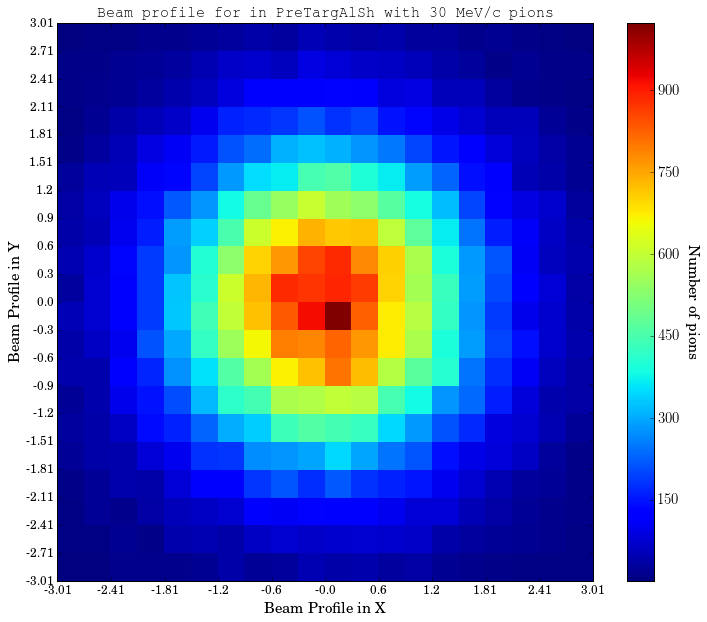

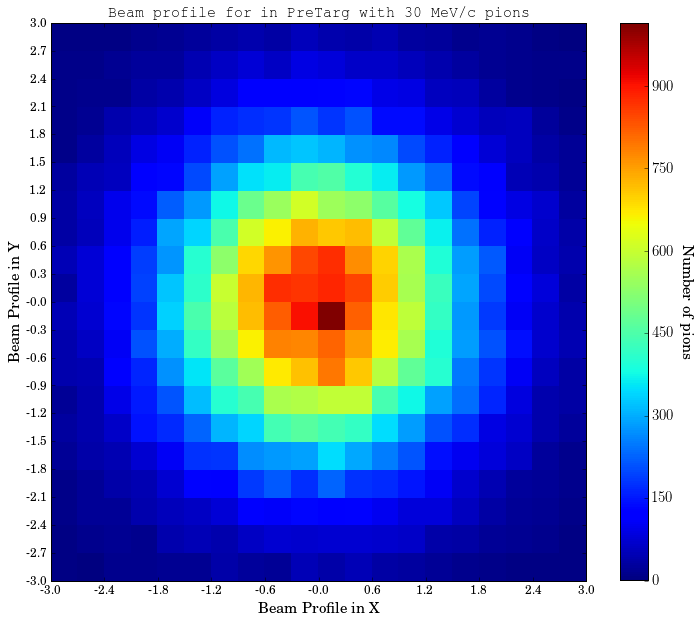

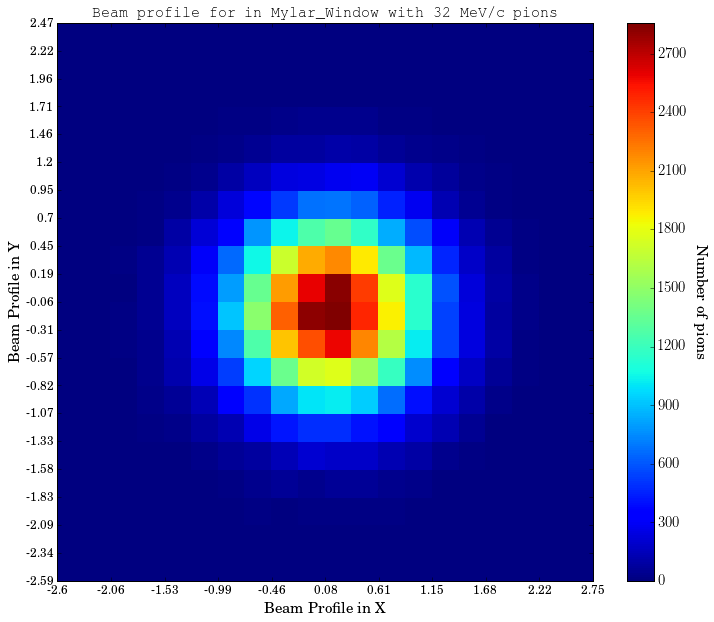

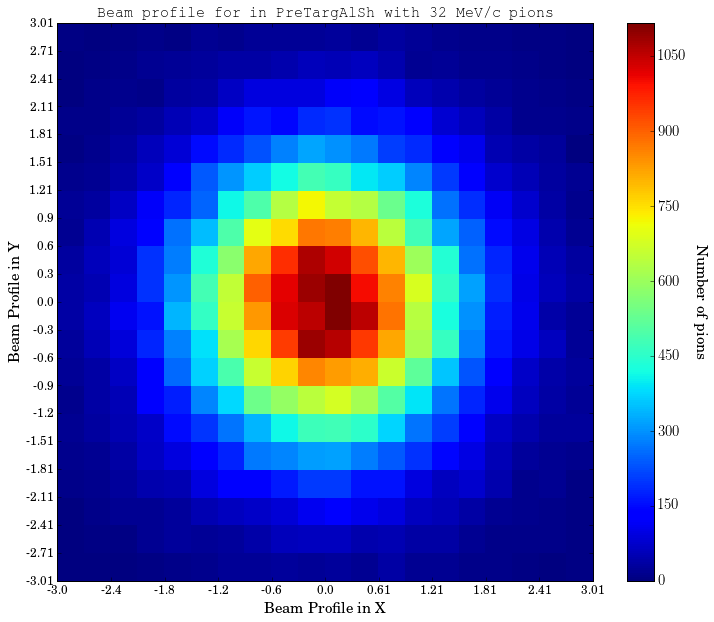

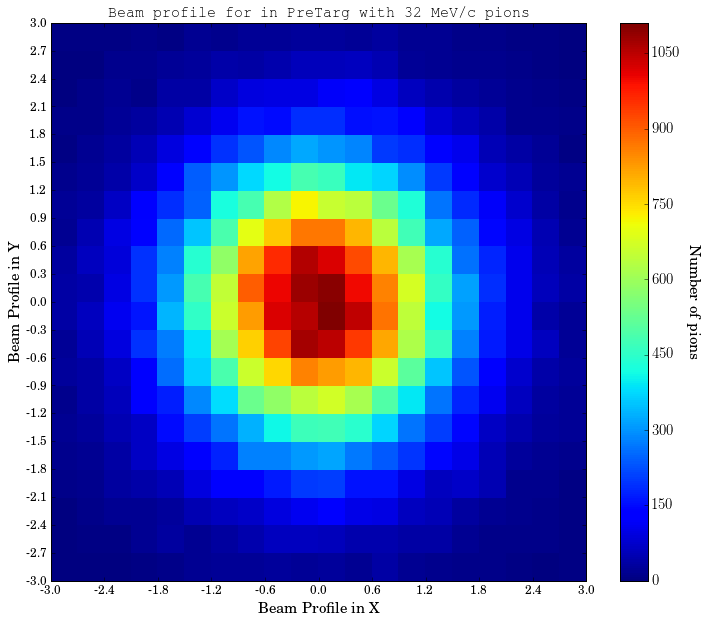

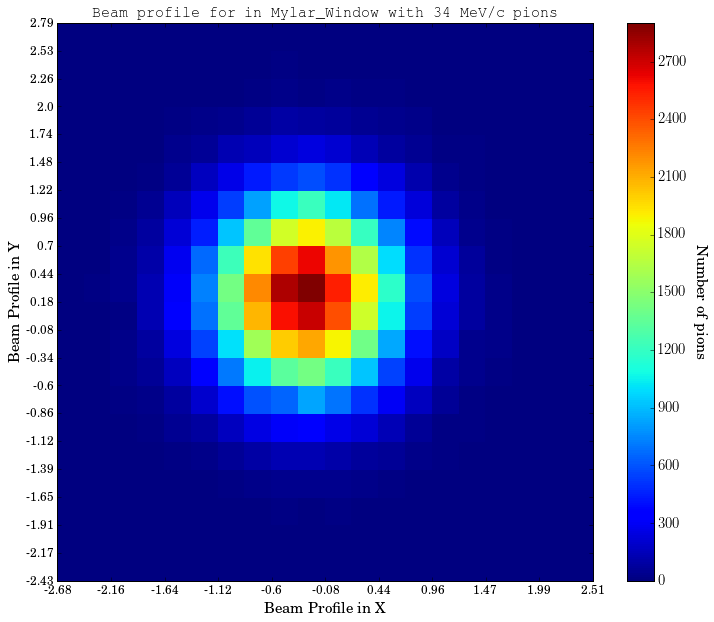

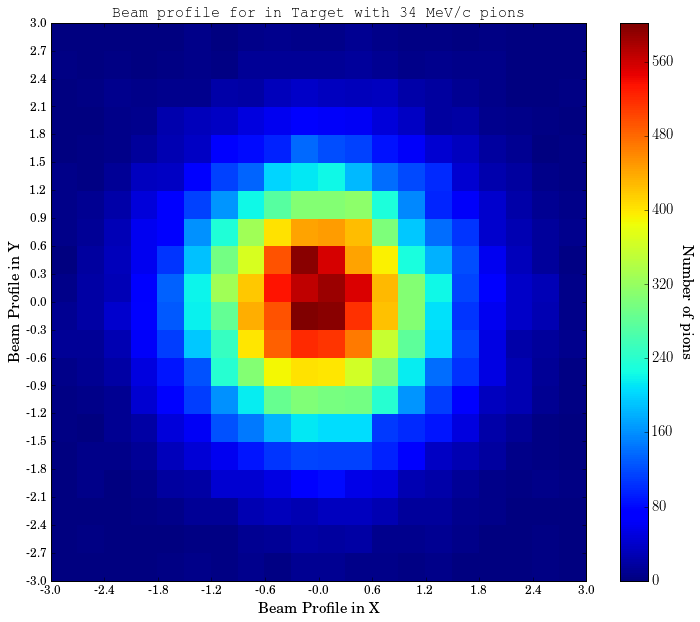

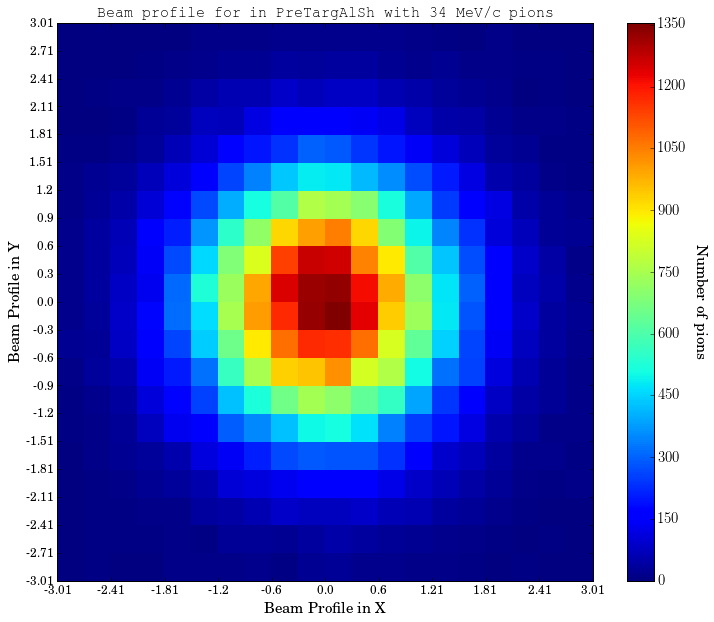

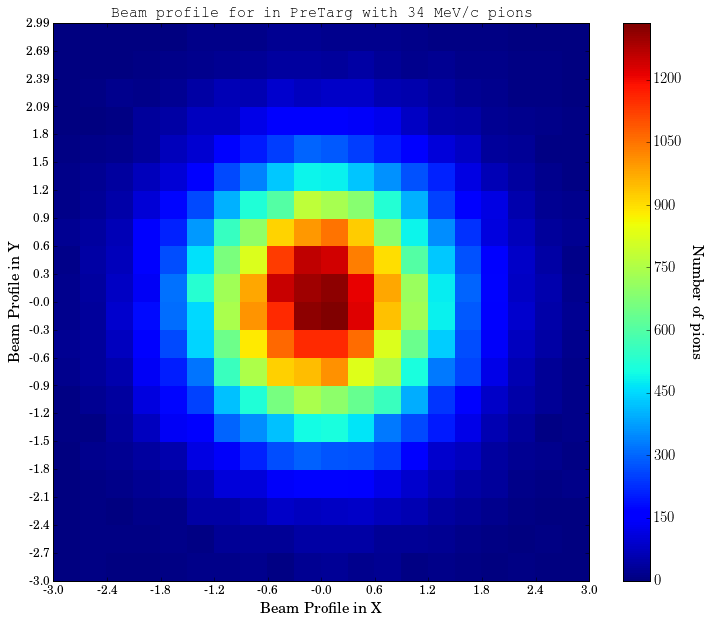

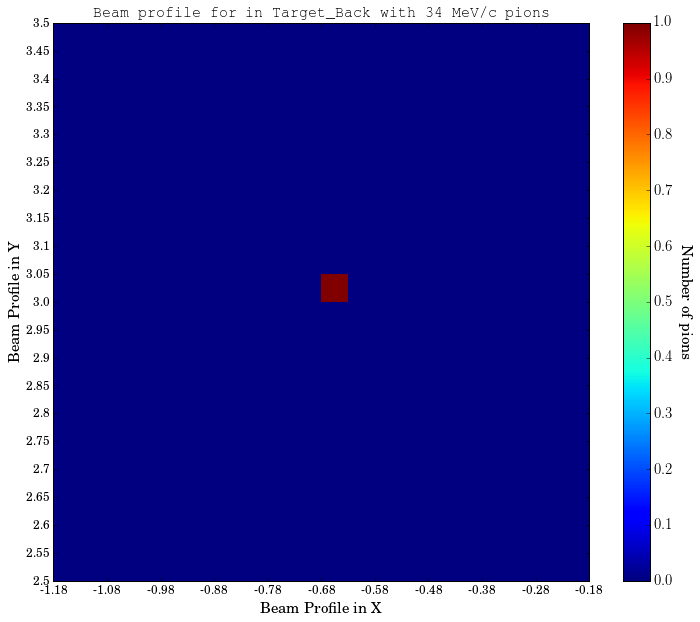

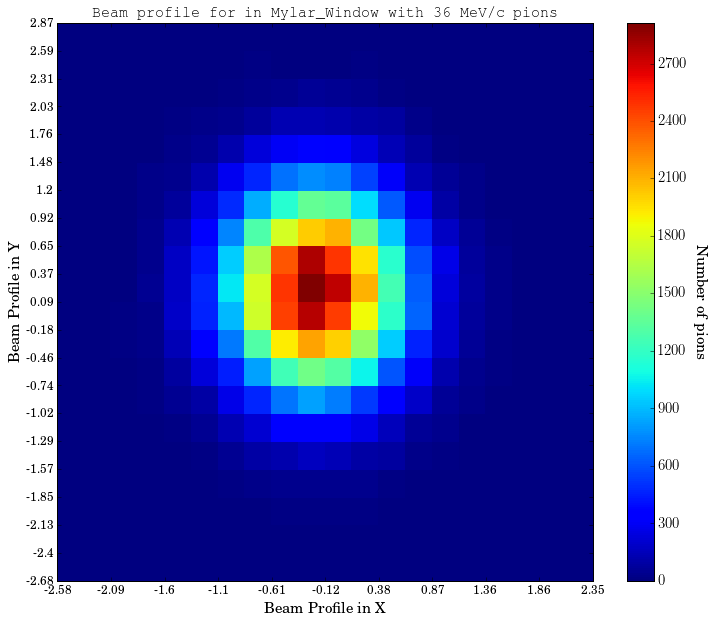

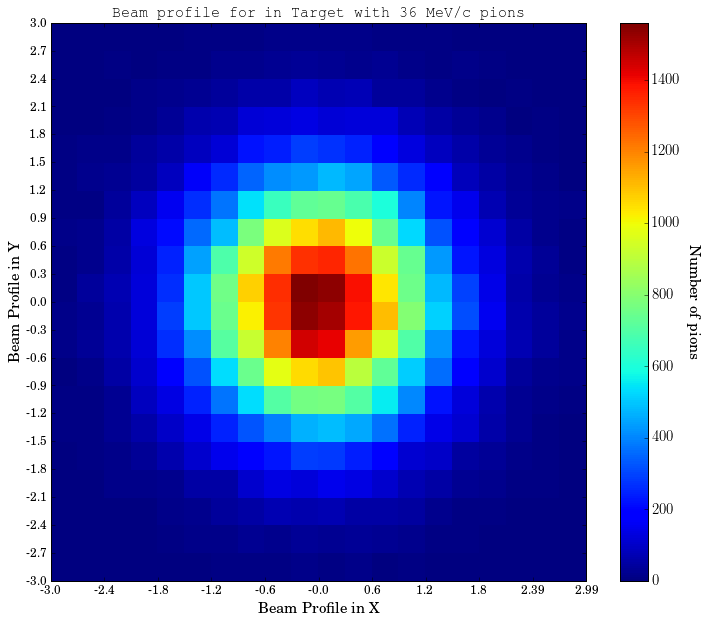

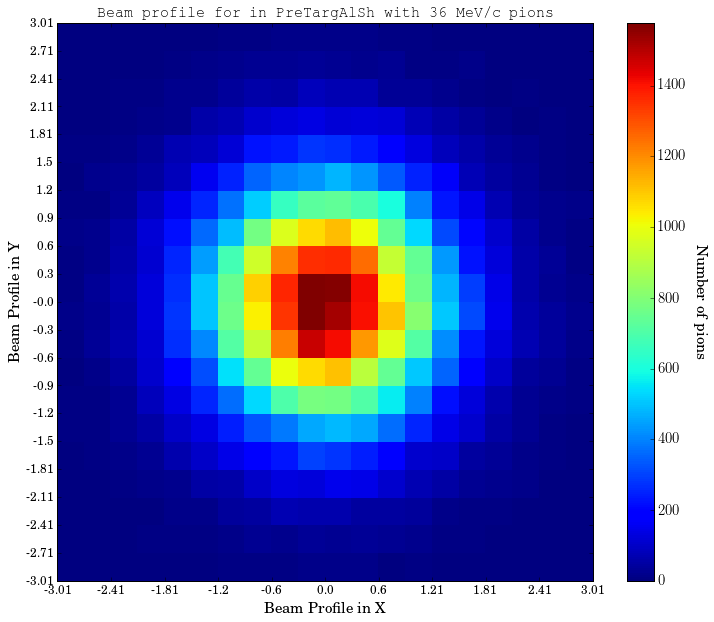

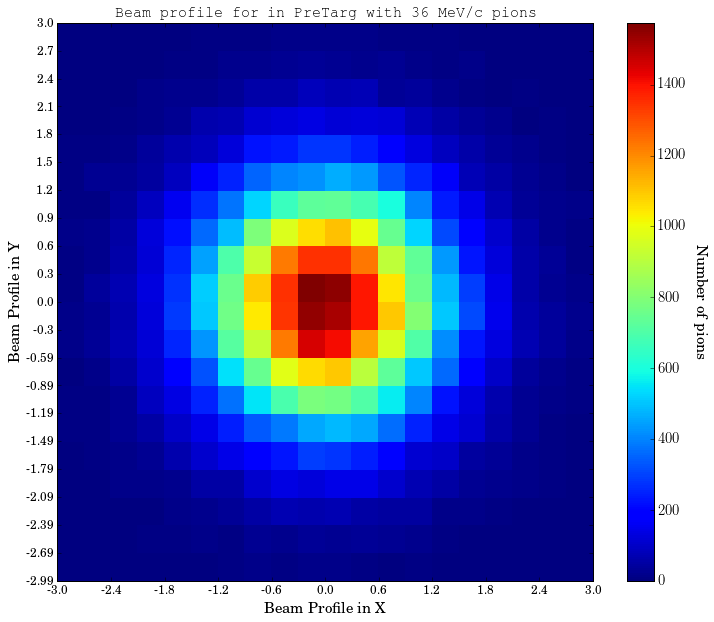

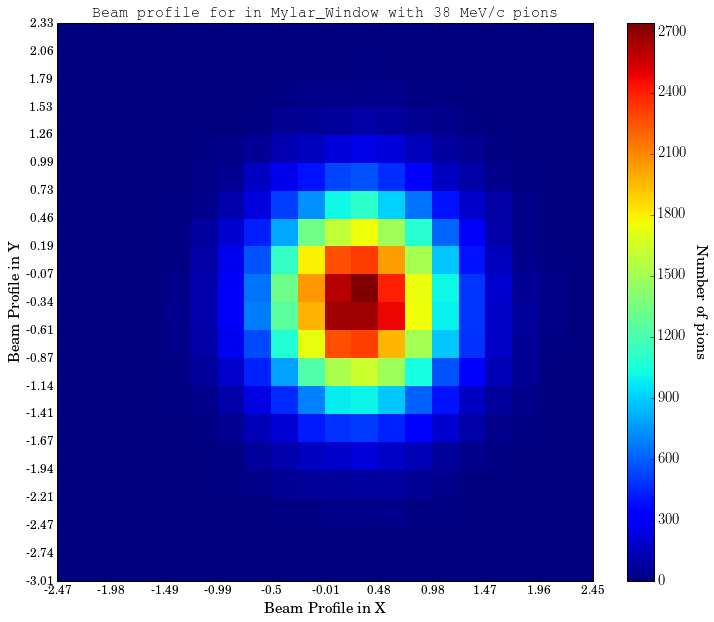

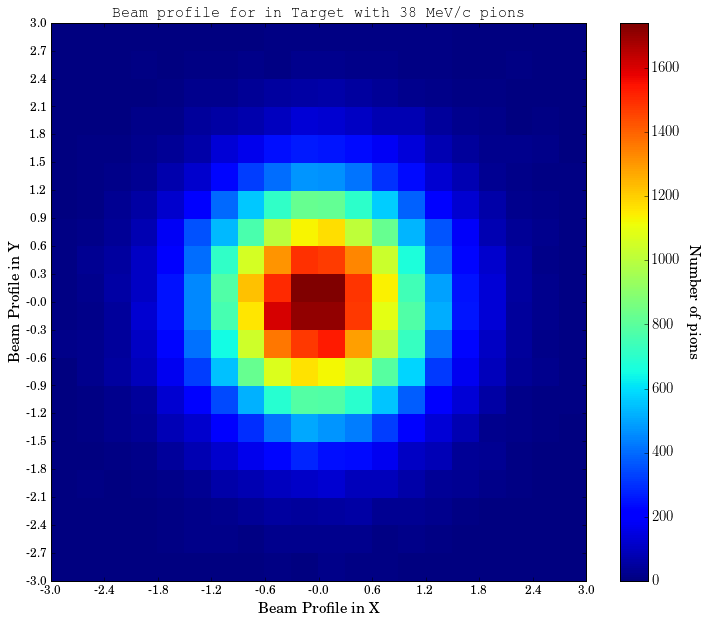

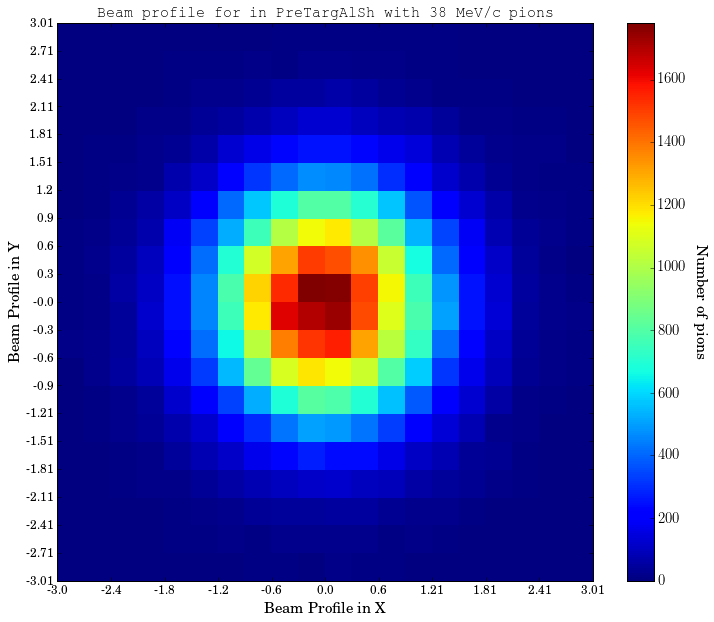

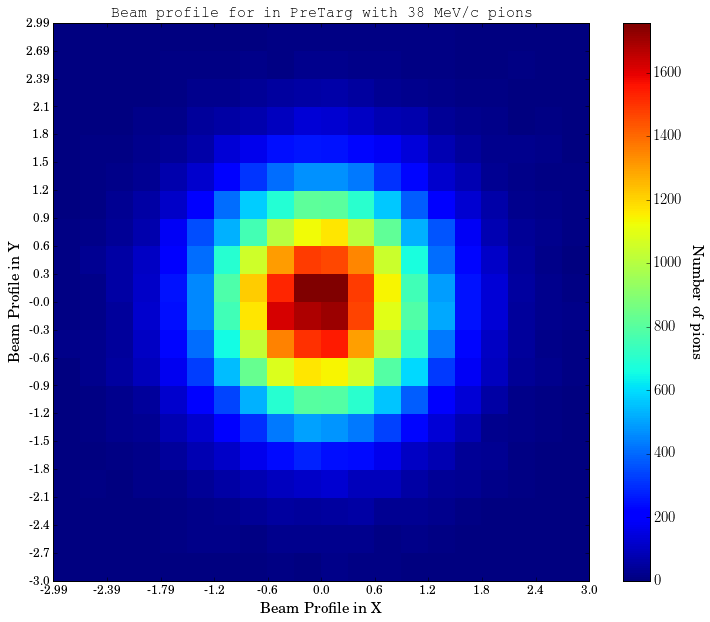

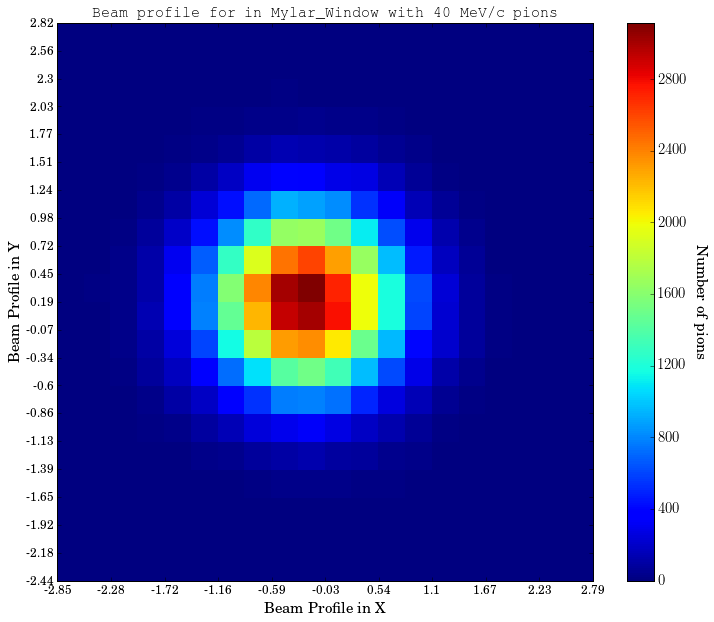

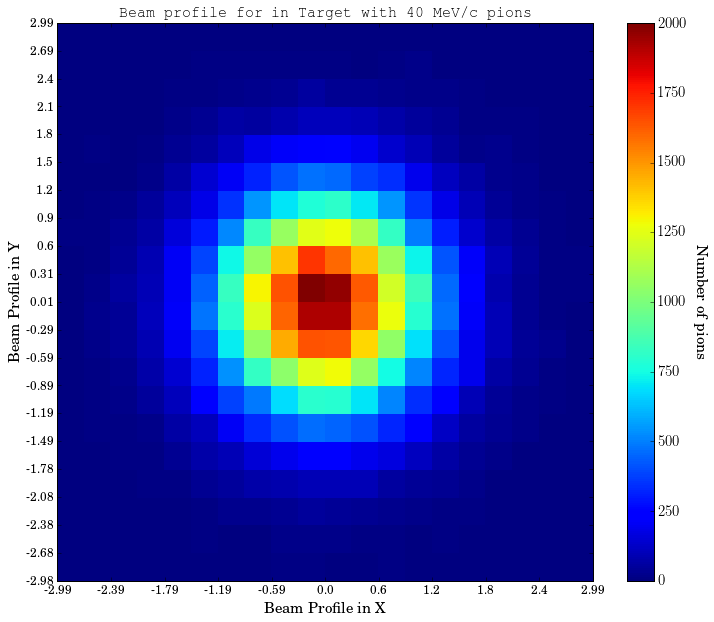

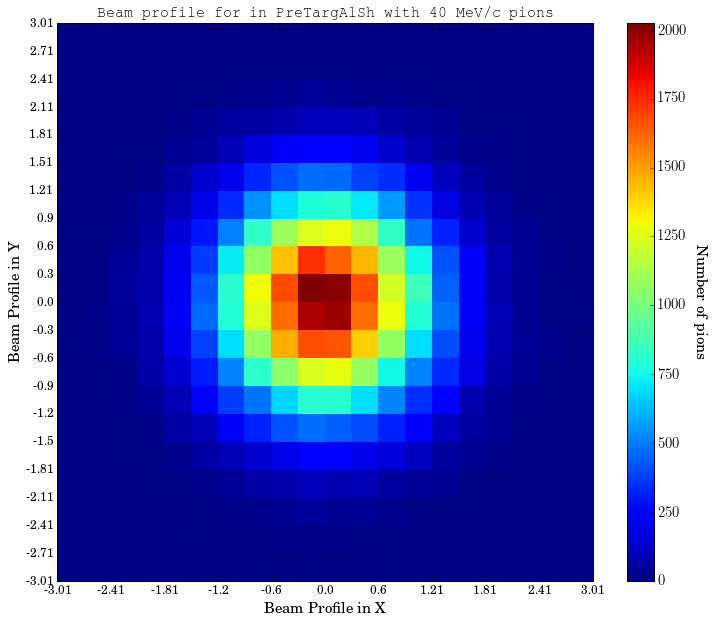

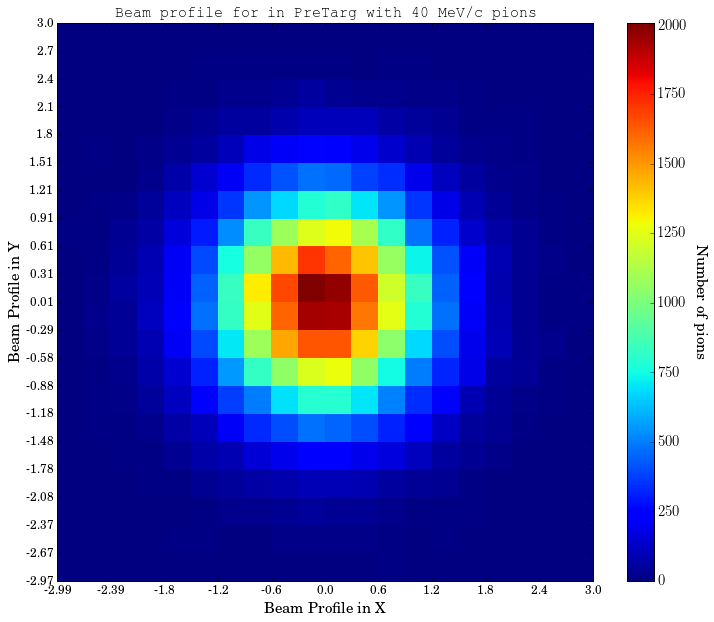

In [9]:
## Plot distribution histograms
for histo in dist_histos:
    # Get fields back for histograms
    volume = histo.volume
    momentum = histo.momentum
    particle = histo.particle
    
    # Get data back from histograms
    data = histo.data
    both_bins = histo.bin_edges.reshape(2,-1)
    bins_x = both_bins[0]
    bins_y = both_bins[1]
                
    # Make some labels
    hist_x_label="Beam Profile in X"
    hist_y_label=r"Beam Profile in Y" 
    hist_z_label="Number of "+particle
    hist_title  =r"\verb|Beam profile for in "+volume+" with "+momentum+" MeV/c "+paricle+"|"

    # Save this information somewhere
    hist_dirname = geom_dir+"/beam_profiles/"+volume
    hist_filename="beam_prof_"+paricle+"_"+momentum+"MeV"+"_"+volume

    plot_2d_histogram(data, bins_x, bins_y, title=hist_title,\
                      x_label=hist_x_label, y_label=hist_y_label, z_label=hist_z_label,\
                      filename=hist_filename, dirname=hist_dirname)

In [ ]:
## Plot stopping distribution histograms
for histo in stop_histos:
    # Get fields back for histograms
    volume = histo.volume
    momentum = histo.momentum
    particle = histo.particle
    
    # Get data back from histograms
    data = histo.data
    both_bins = histo.bin_edges.reshape(2,-1)
    bins_x = both_bins[0]
    bins_y = both_bins[1]
                
    # Make some labels
    hist_x_label="Beam Profile in X"
    hist_y_label=r"Beam Profile in Y" 
    hist_z_label="Number of "+particle
    hist_title  =r"\verb|Stopping profile for in "+volume+" with "+momentum+" MeV/c "+paricle+"|"   
    
    # Save this information somewhere
    hist_dirname = geom_dir+"/stopped_profiles/"+volume
    hist_filename="stop_prof_"+paricle+"_"+momentum+"MeV"+"_"+volume

    plot_2d_histogram(data, bins_x, bins_y, title=hist_title,\
                      x_label=hist_x_label, y_label=hist_y_label, z_label=hist_z_label,\
                      filename=hist_filename, dirname=hist_dirname)

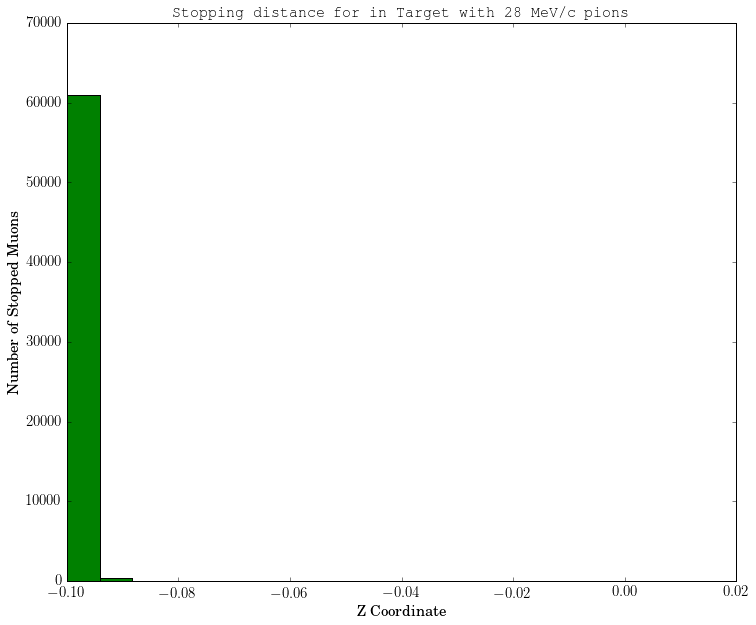

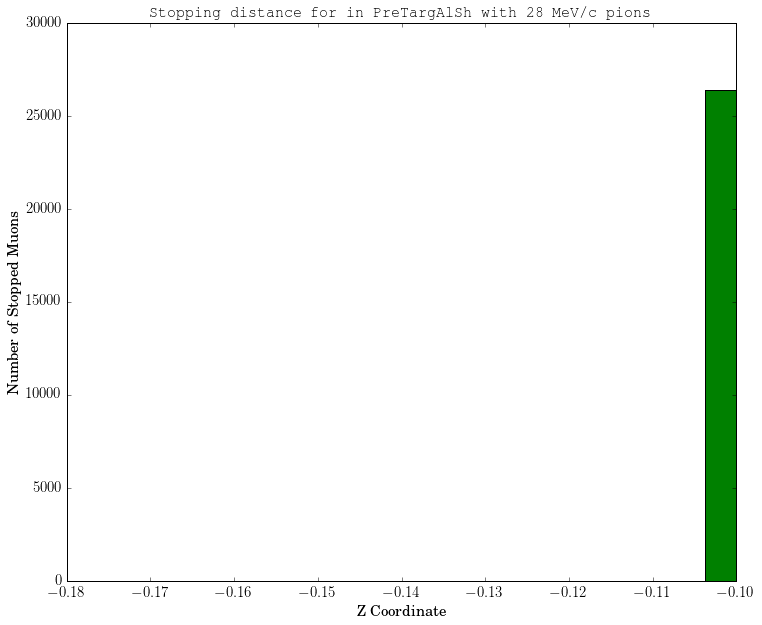

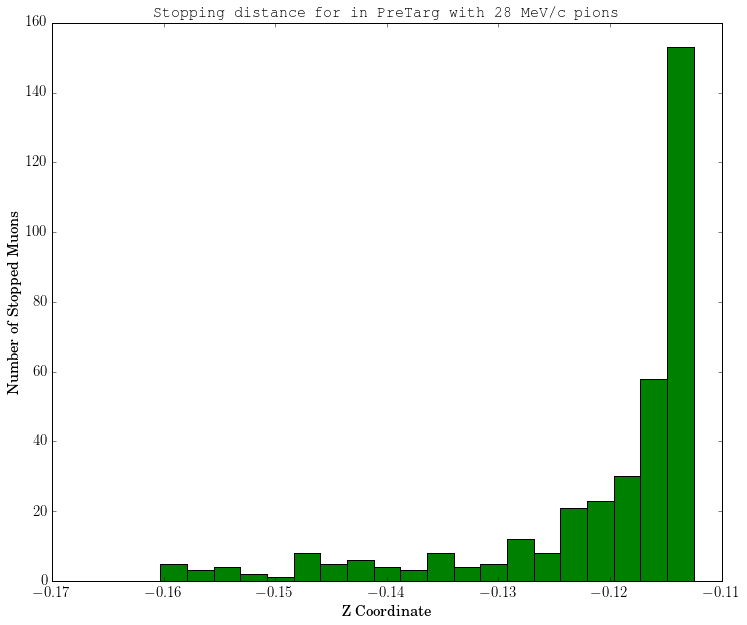

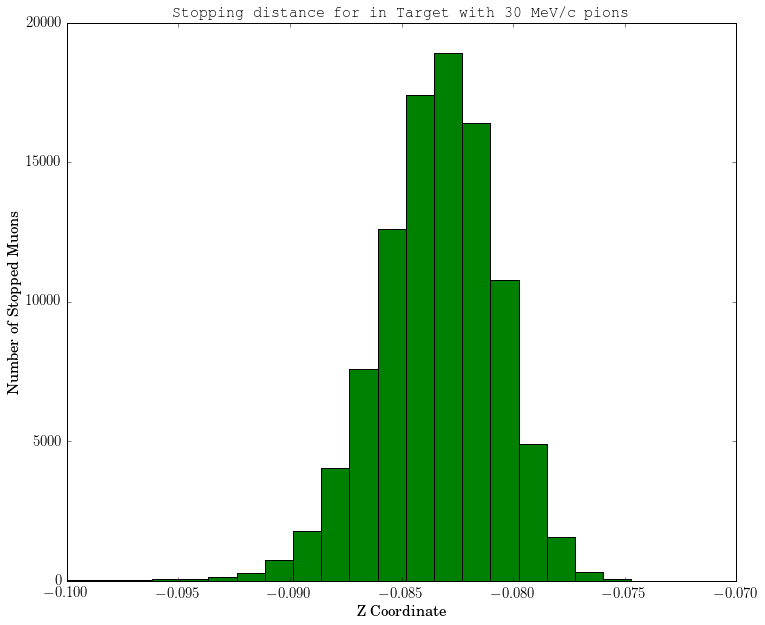

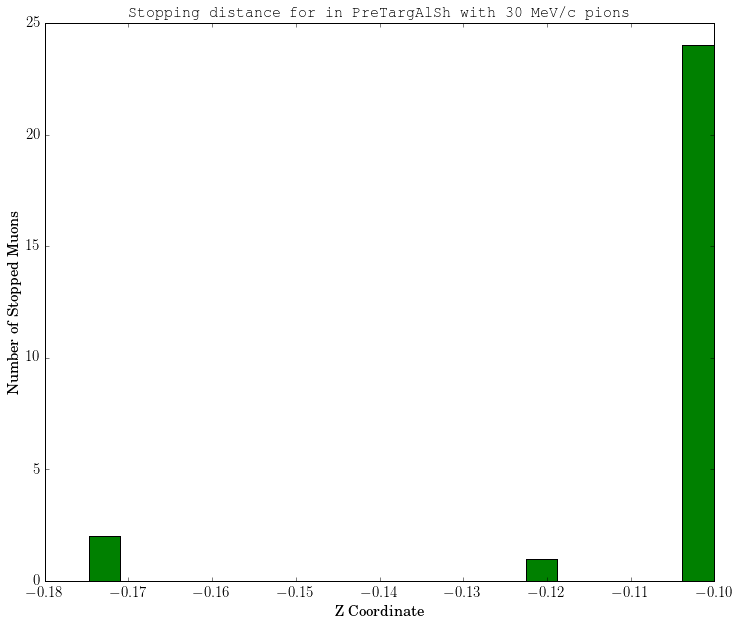

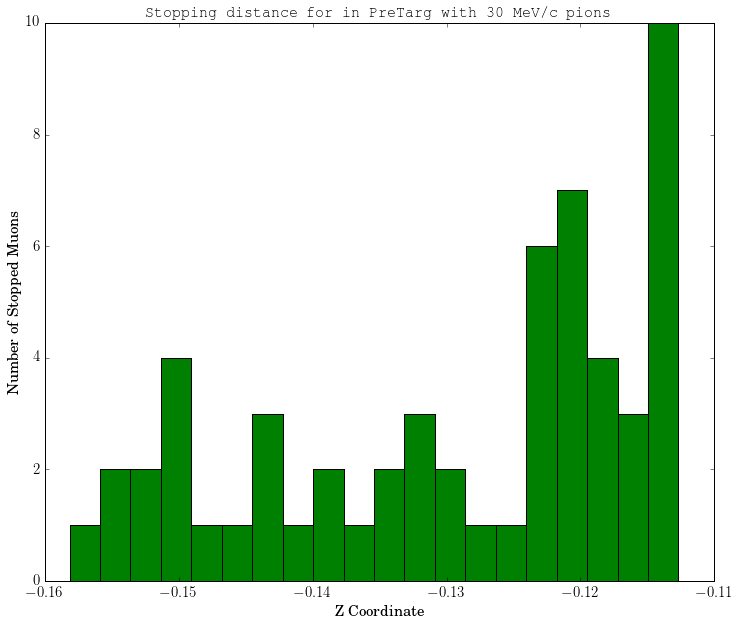

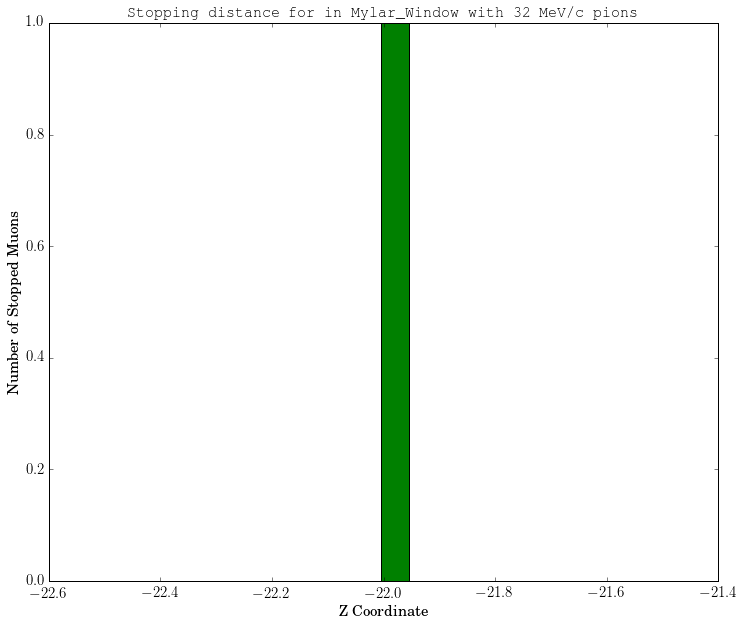

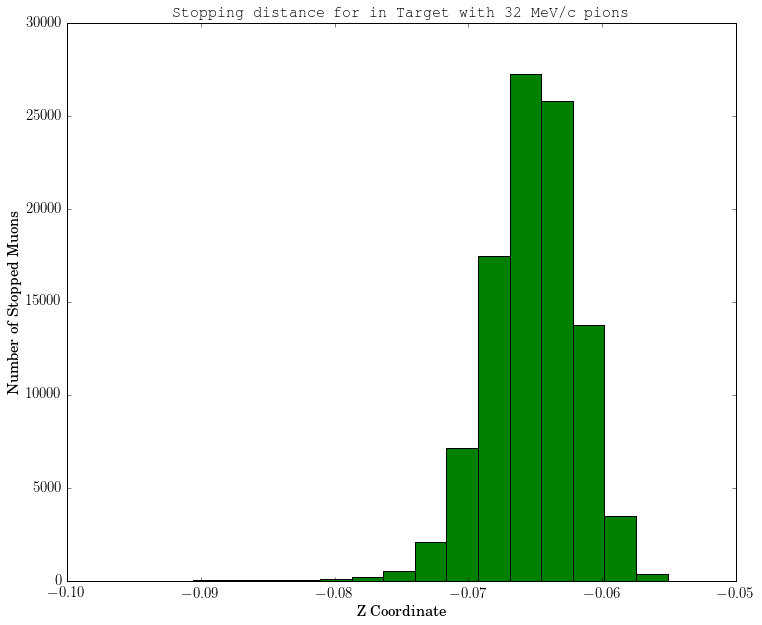

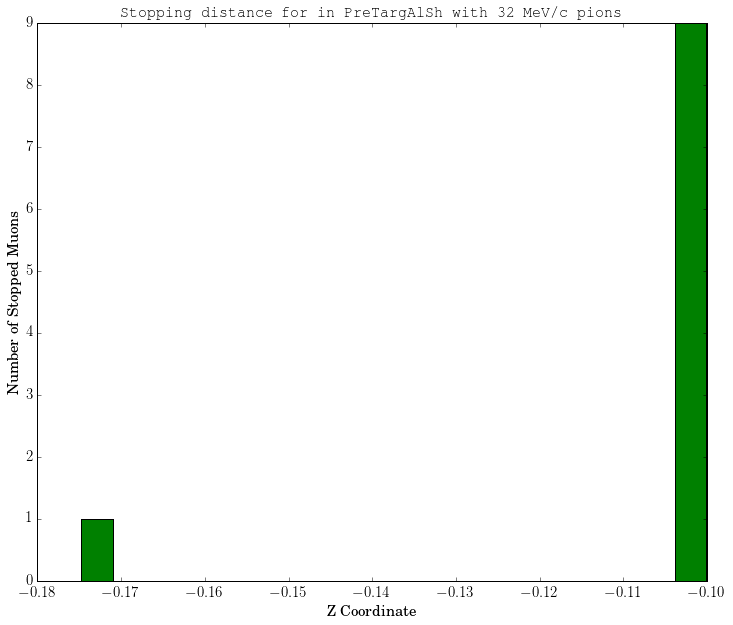

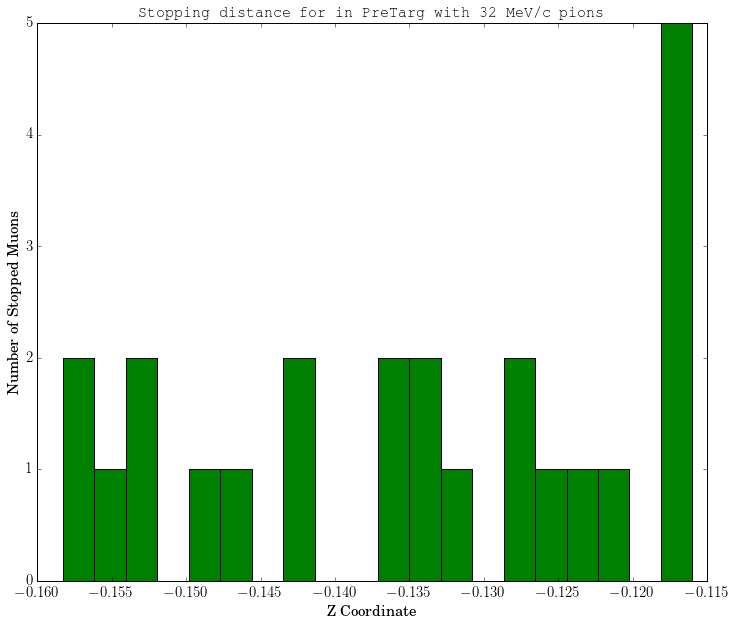

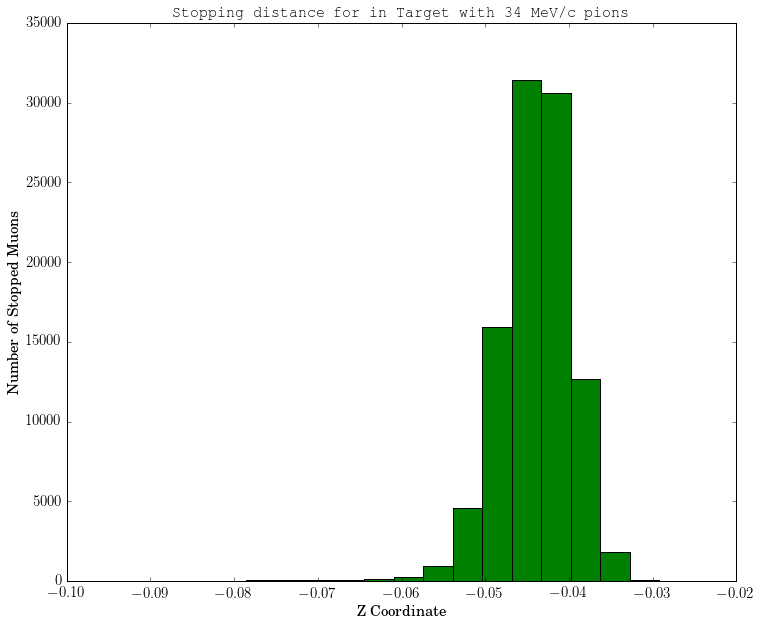

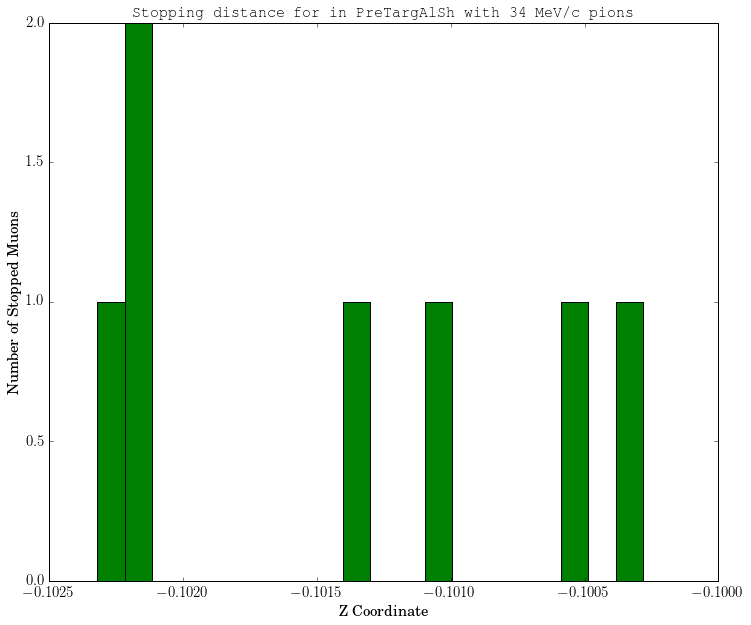

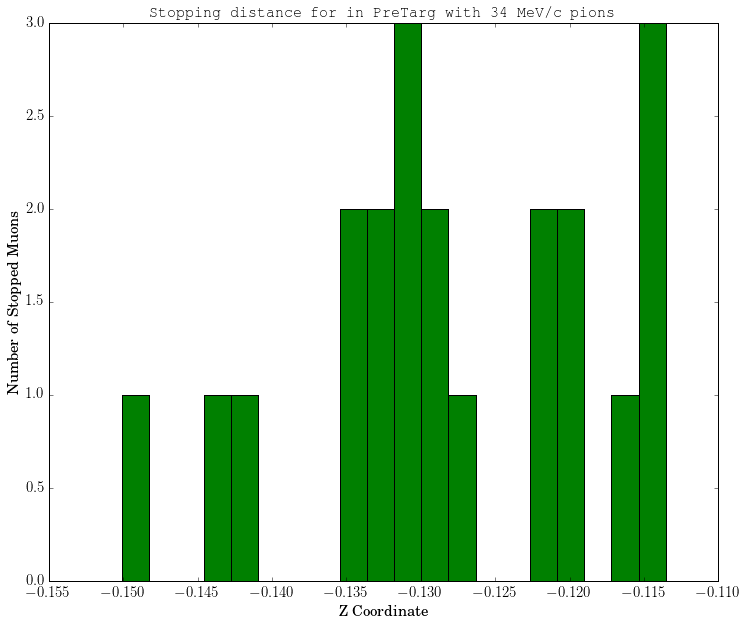

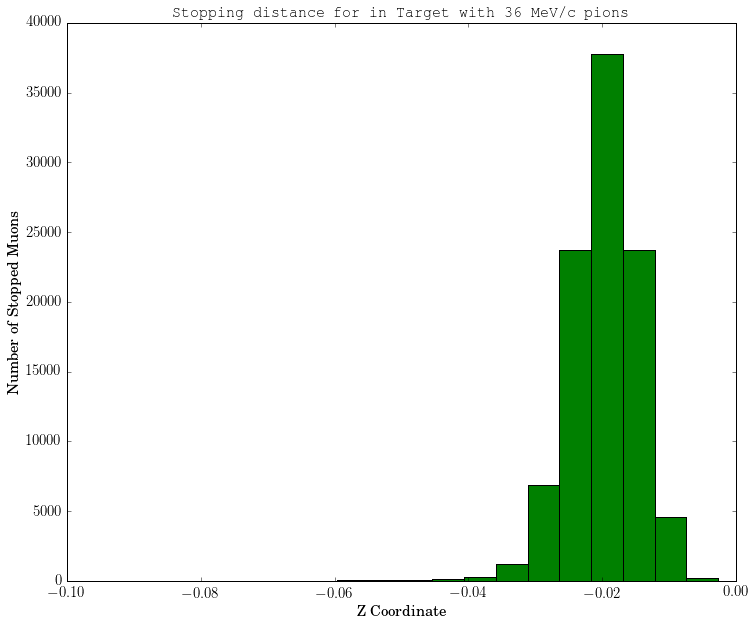

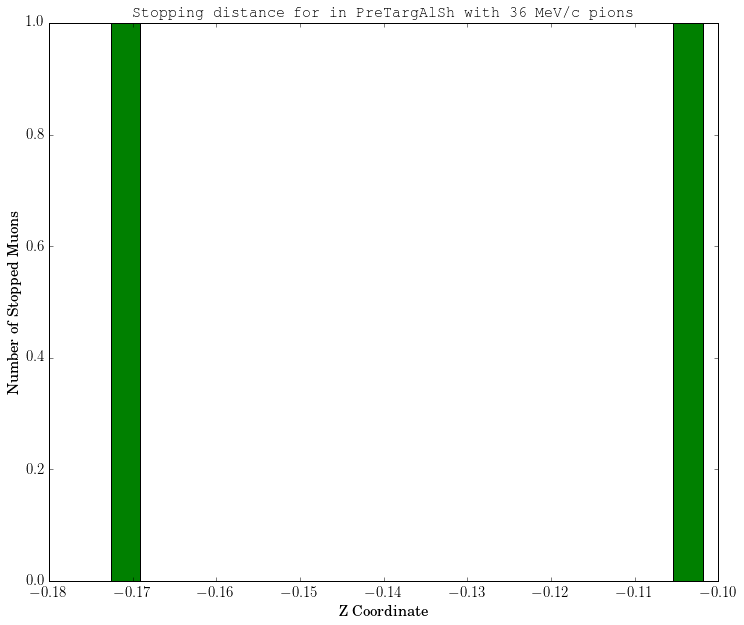

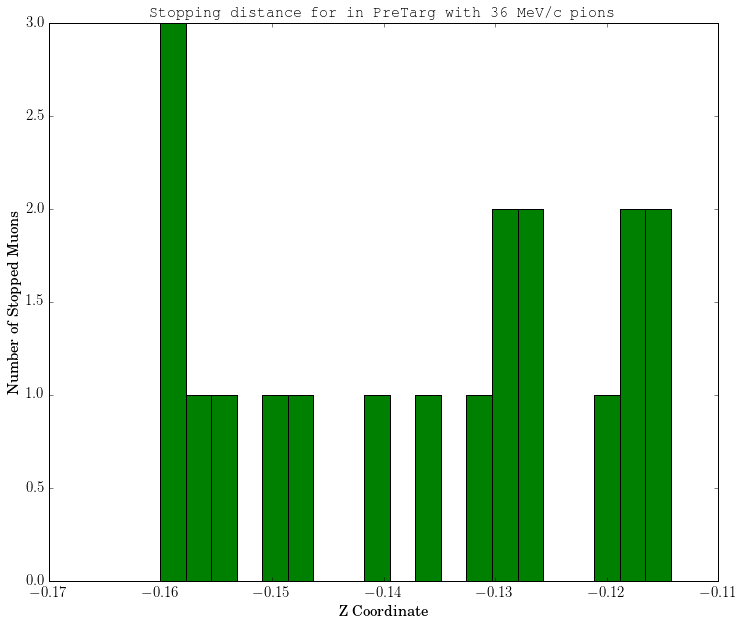

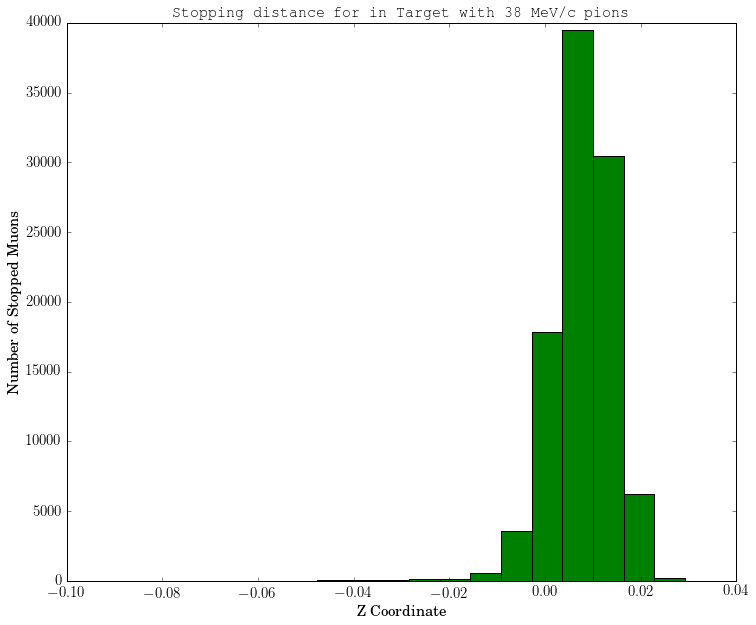

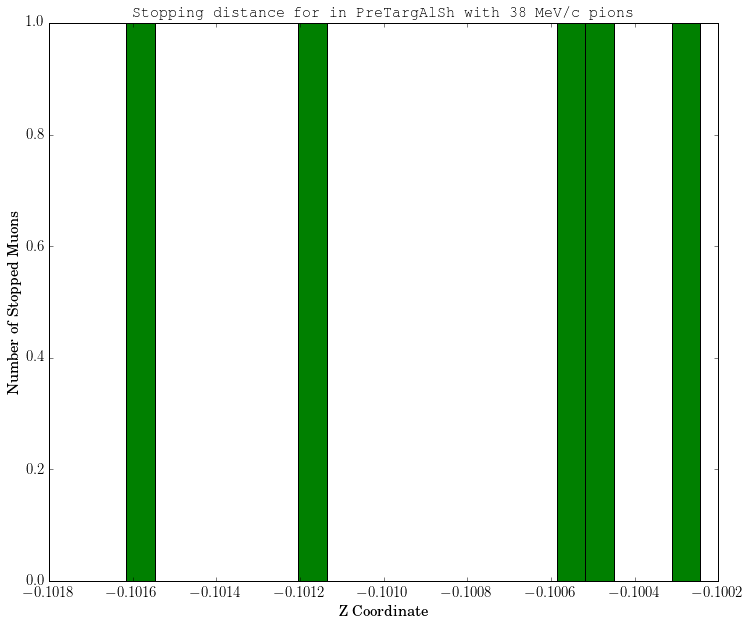

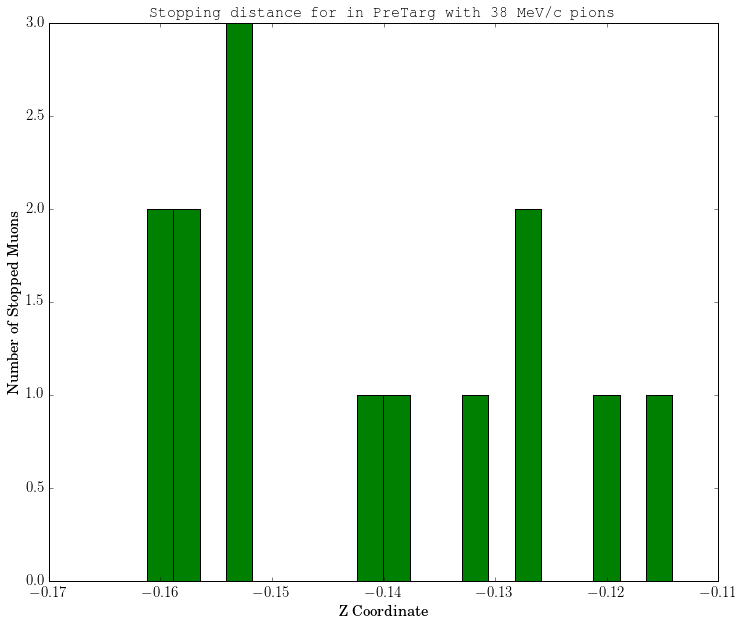

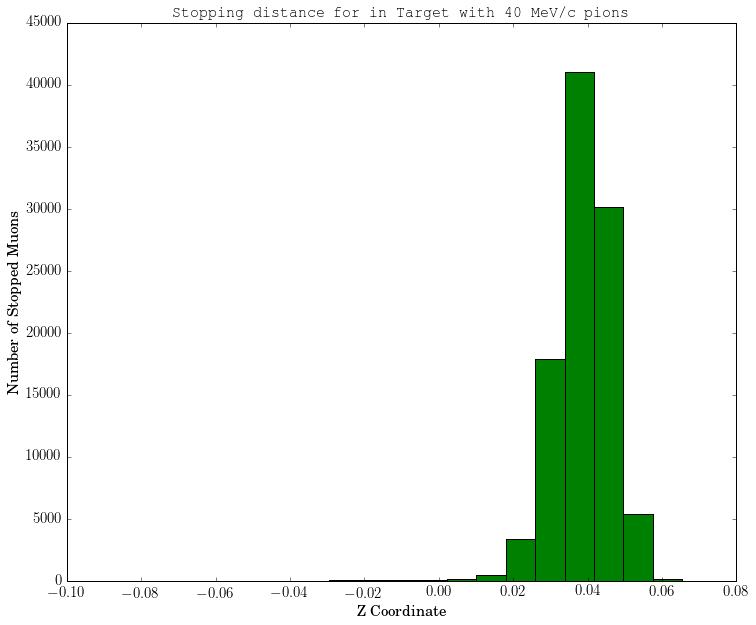

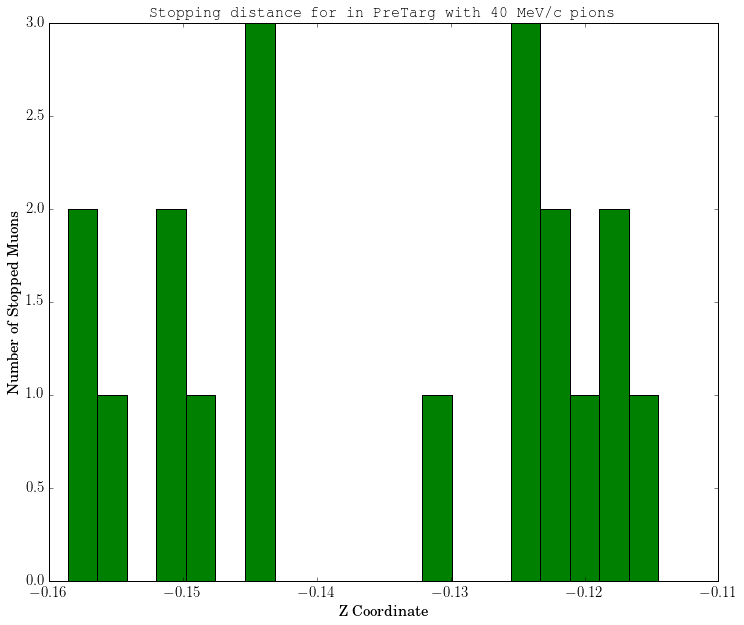

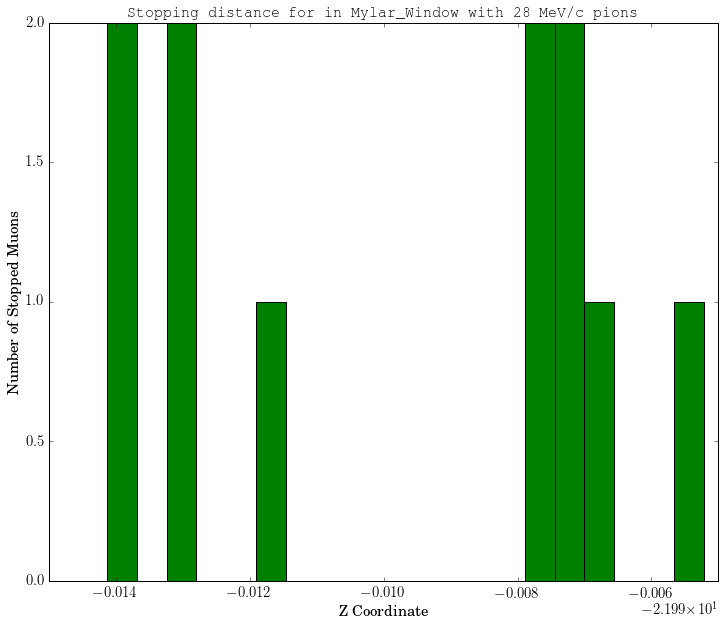

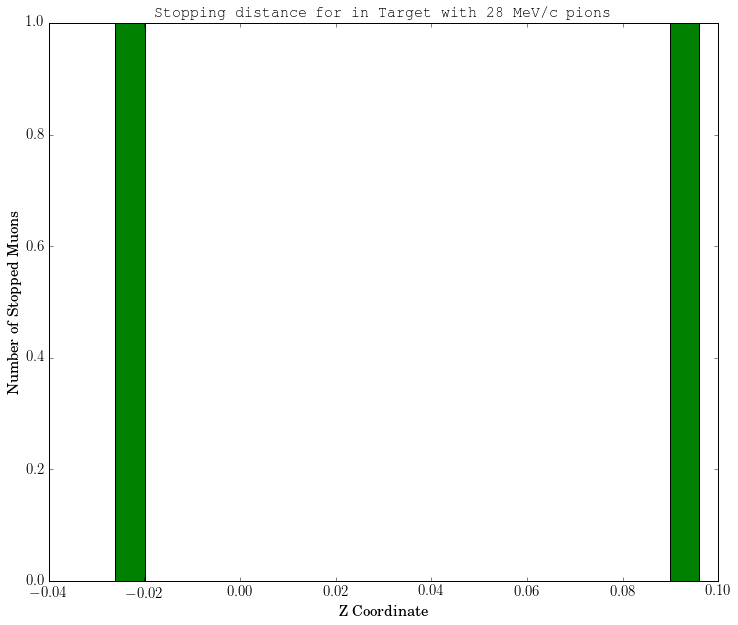

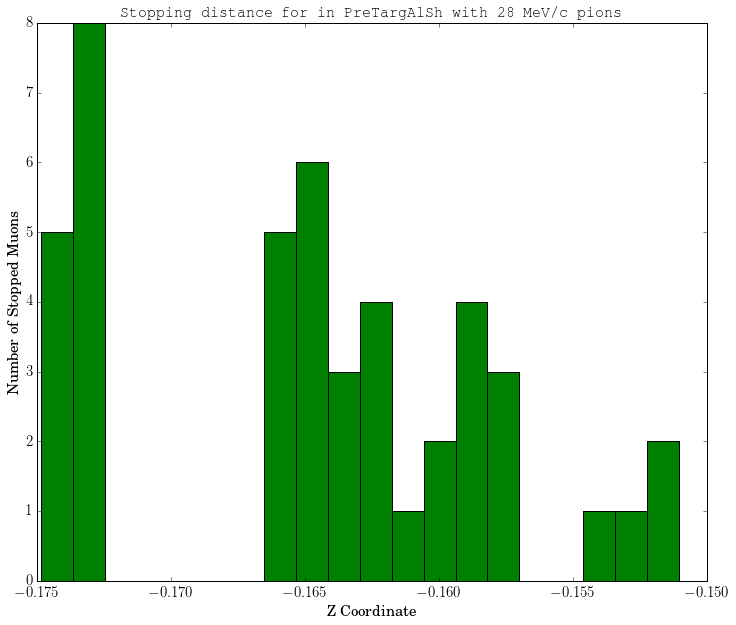

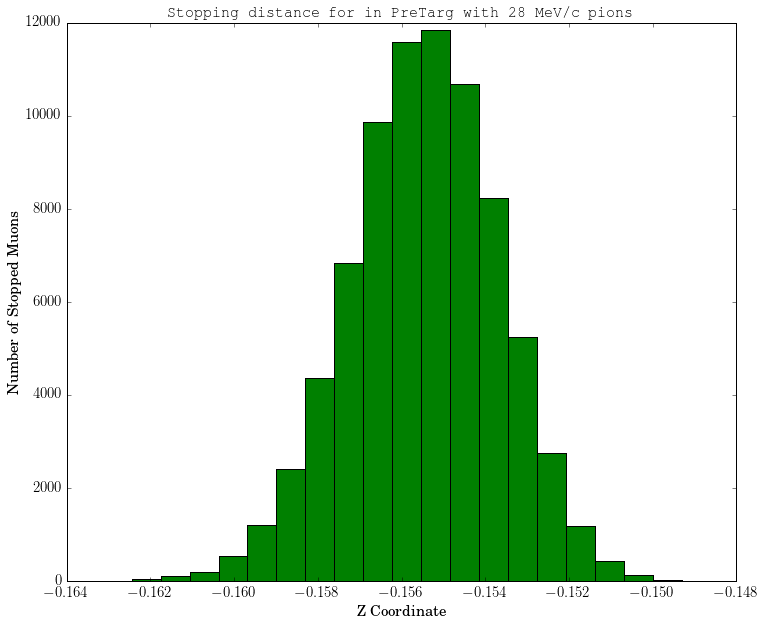

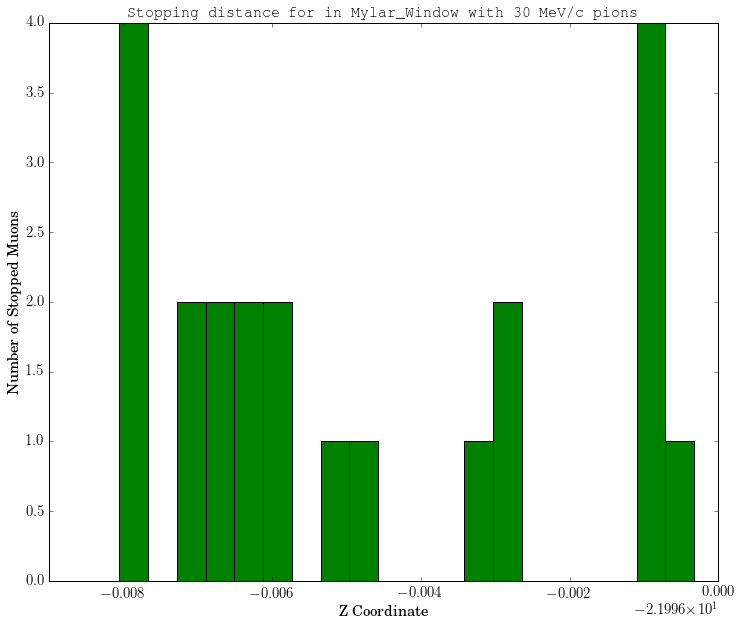

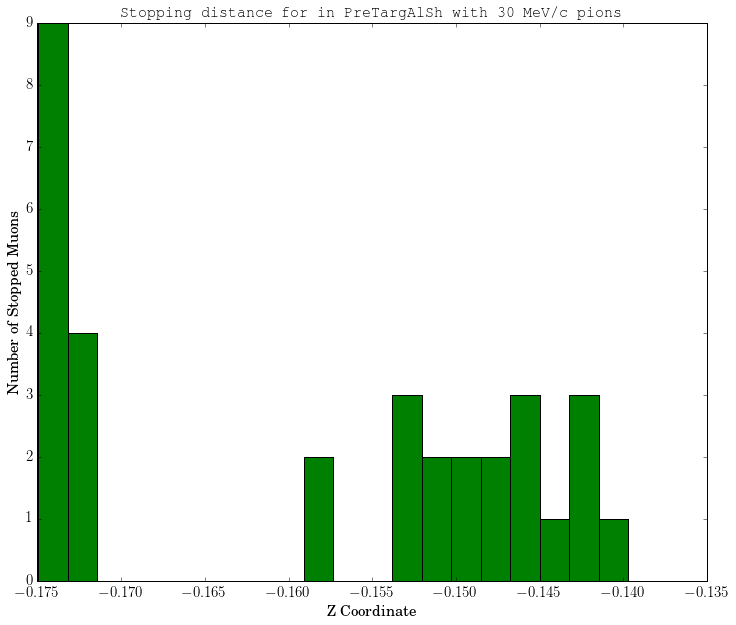

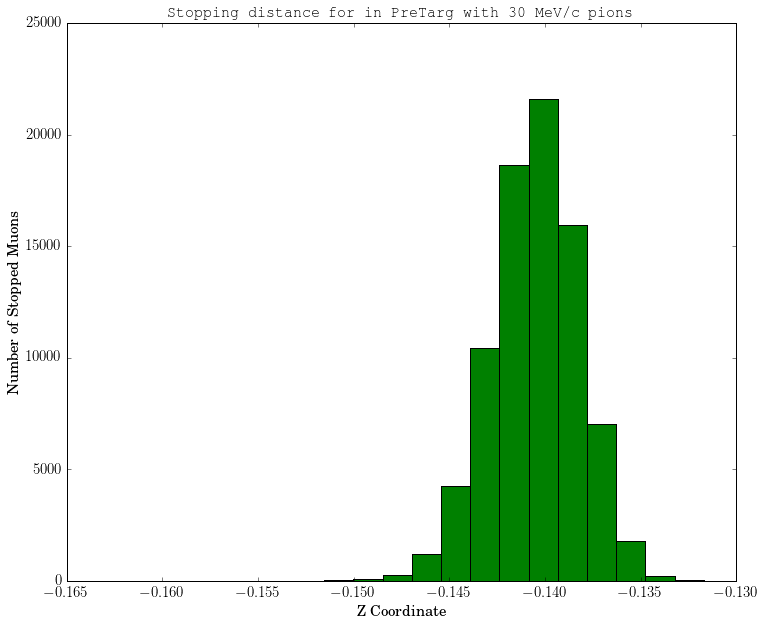

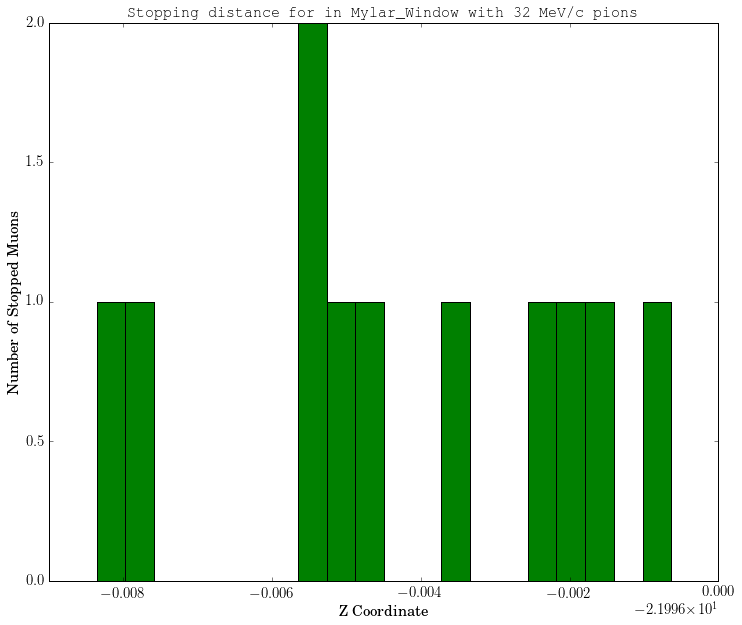

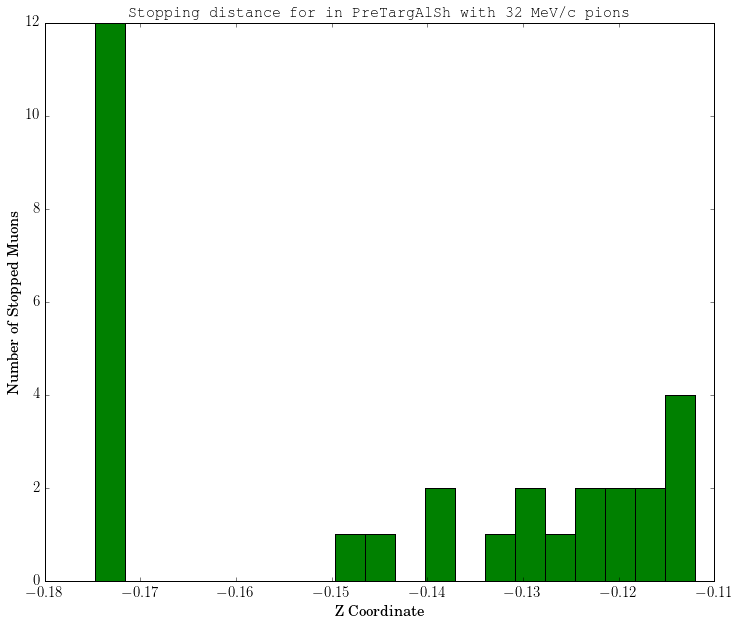

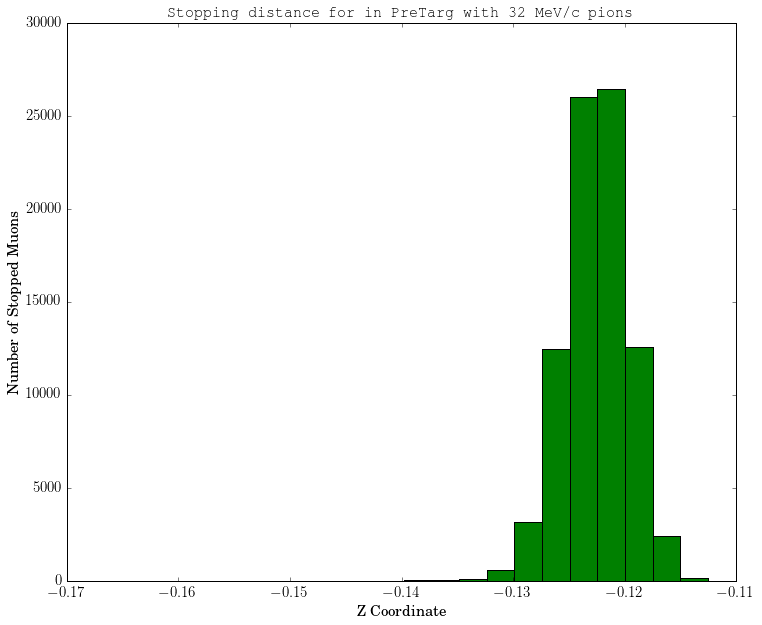

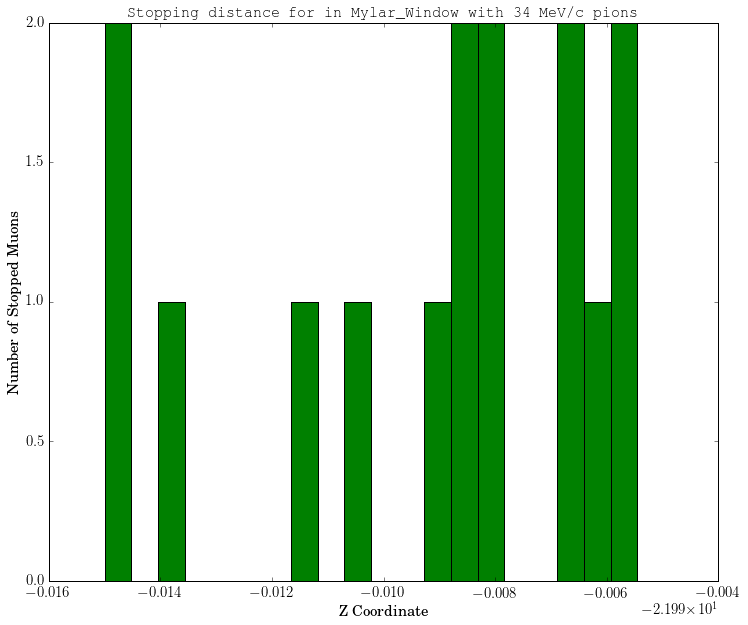

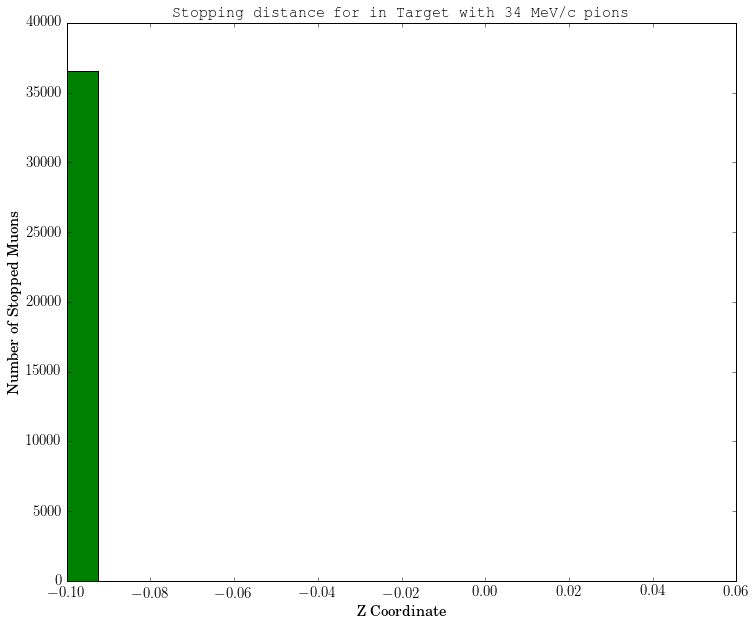

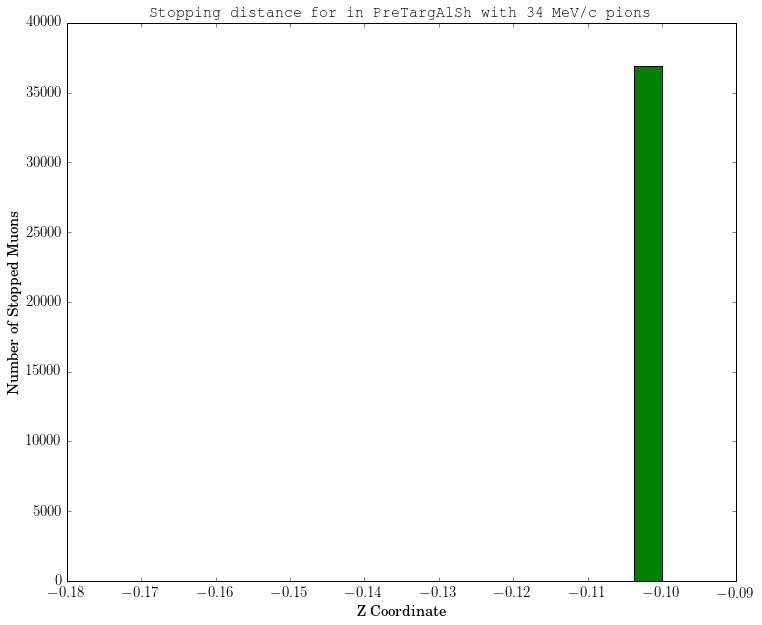

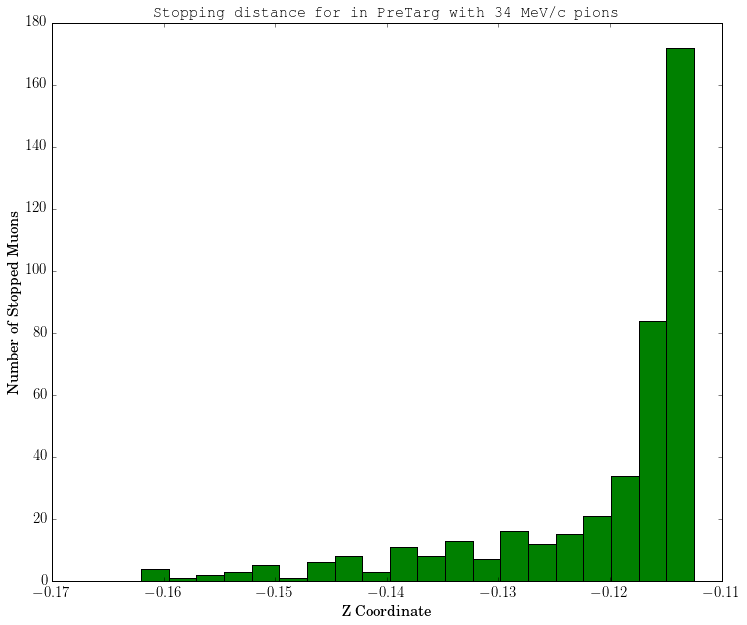

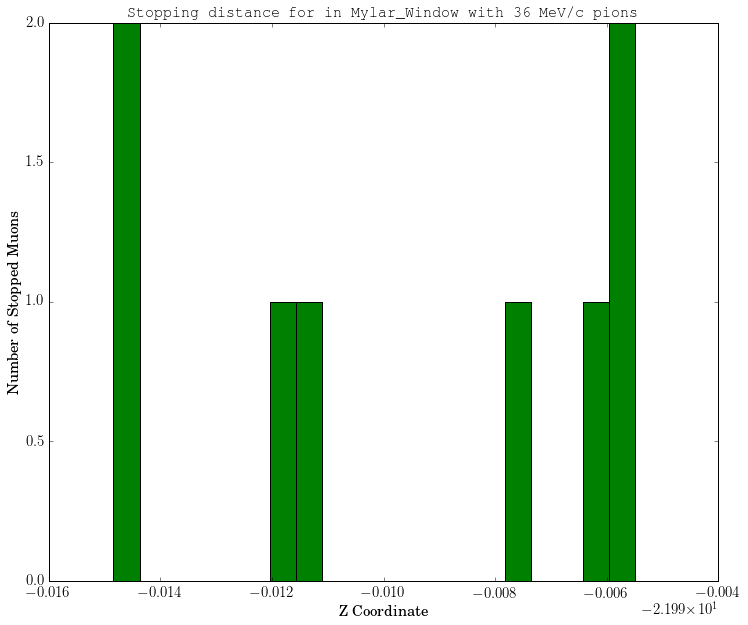

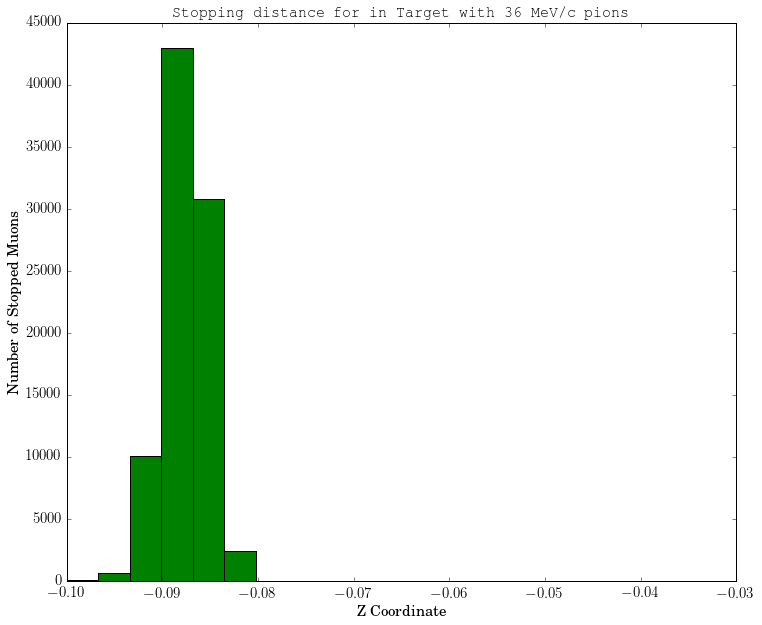

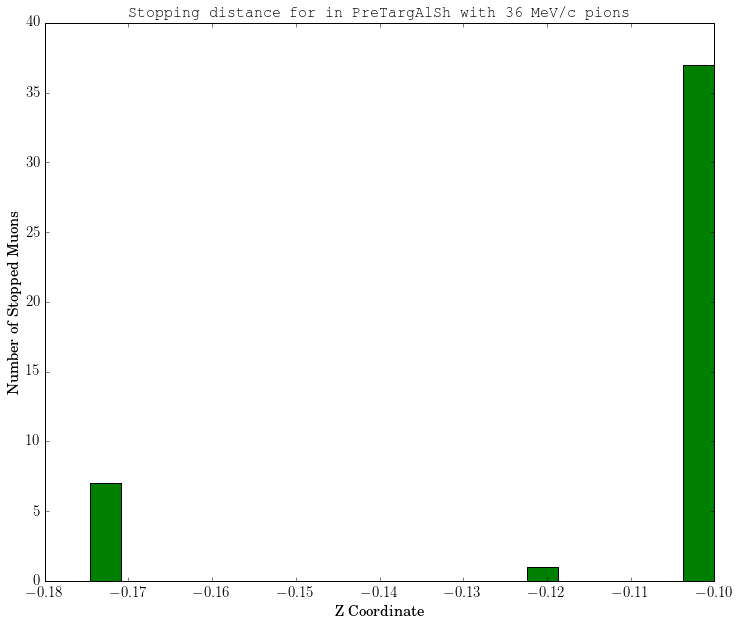

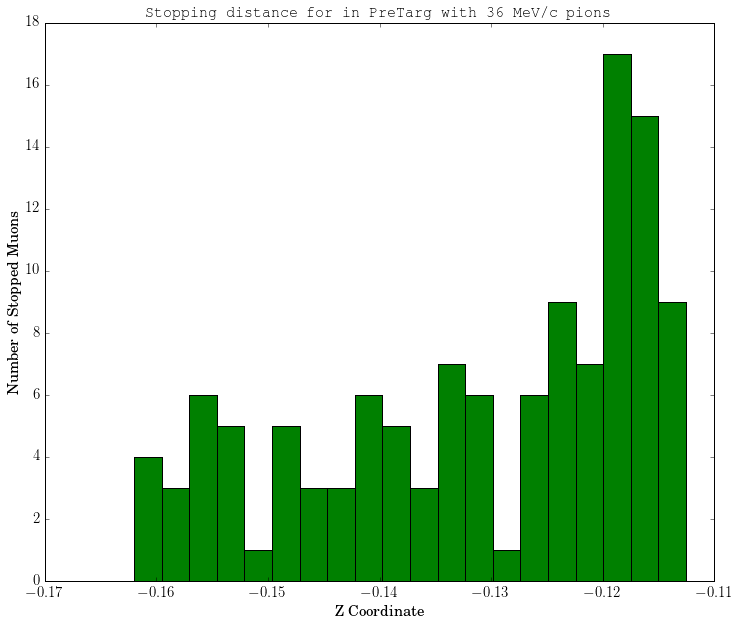

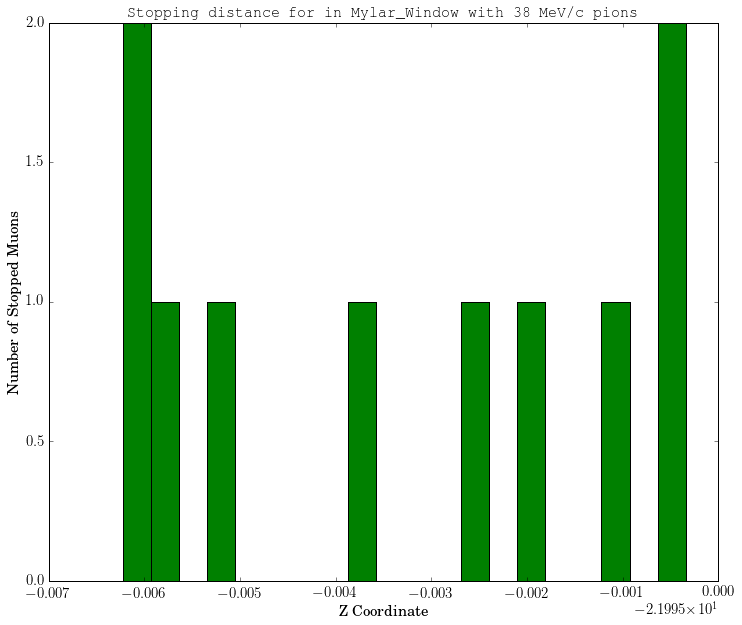

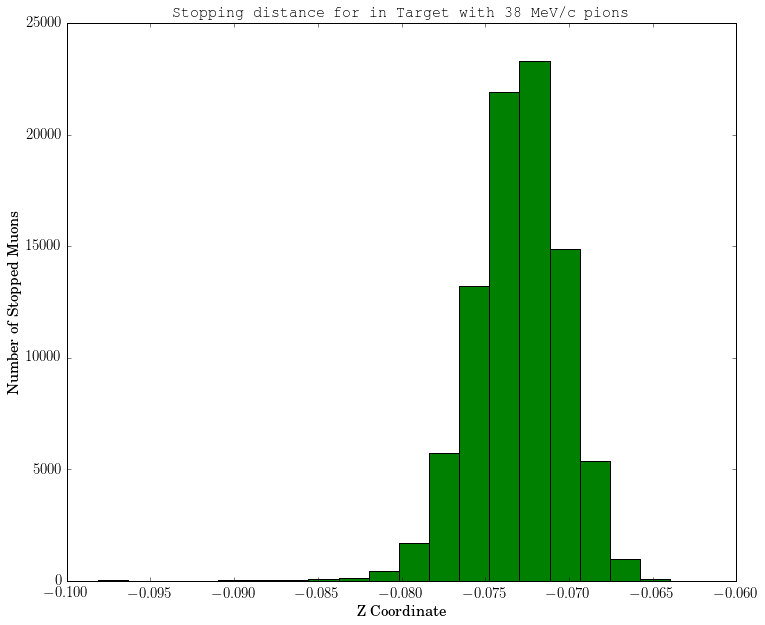

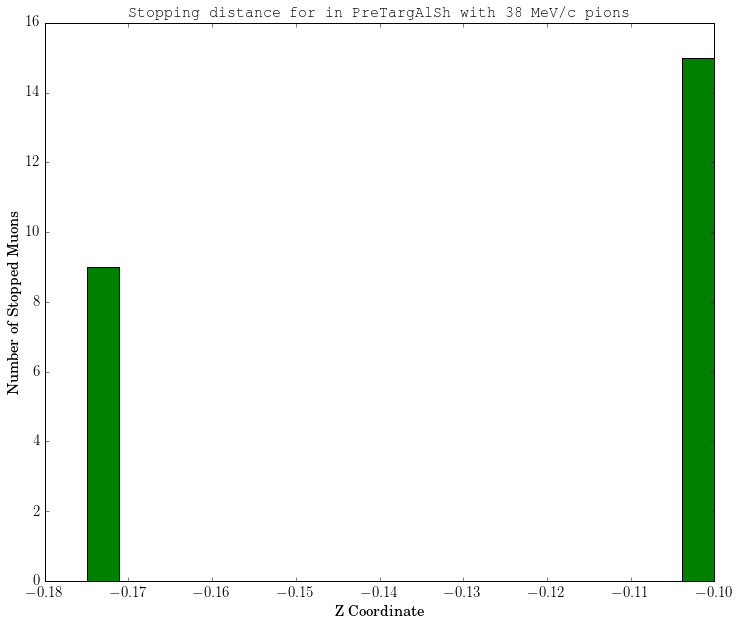

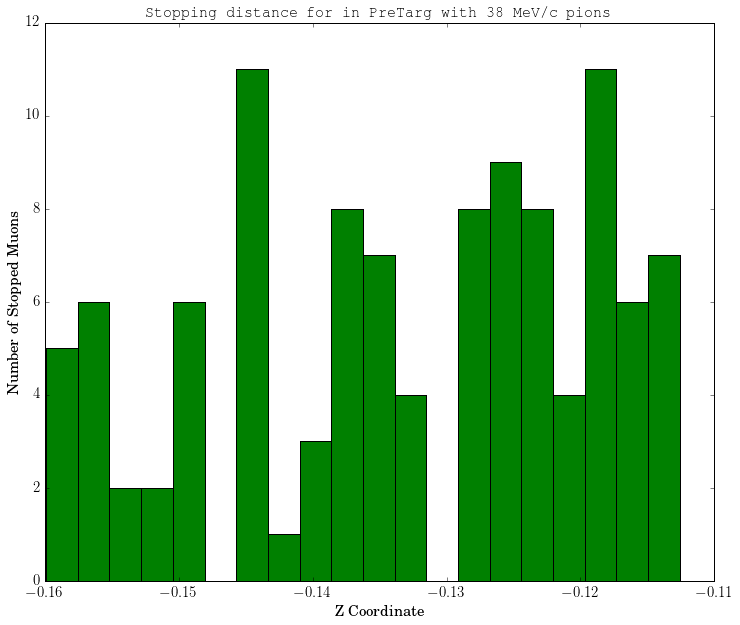

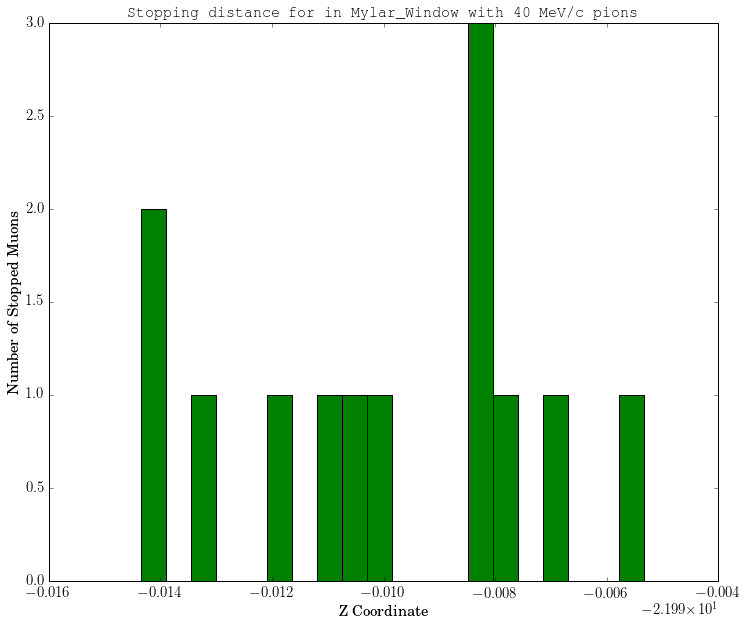

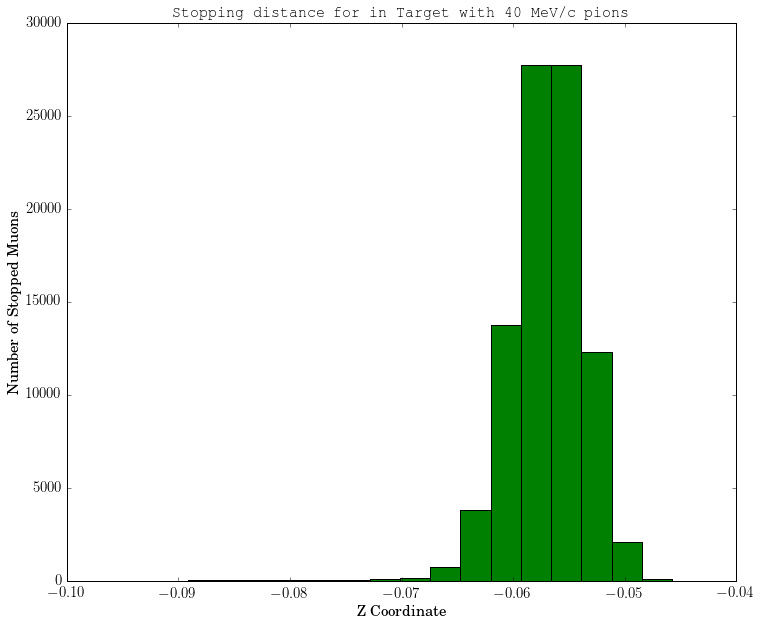

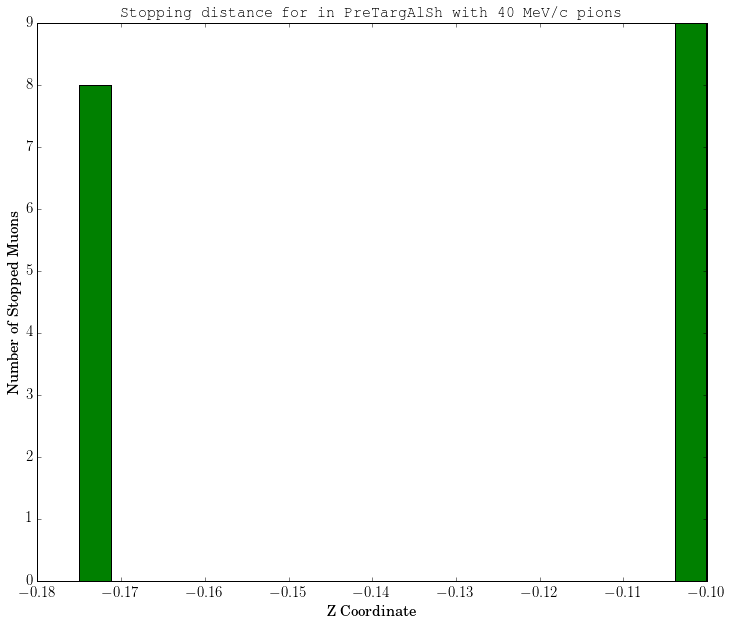

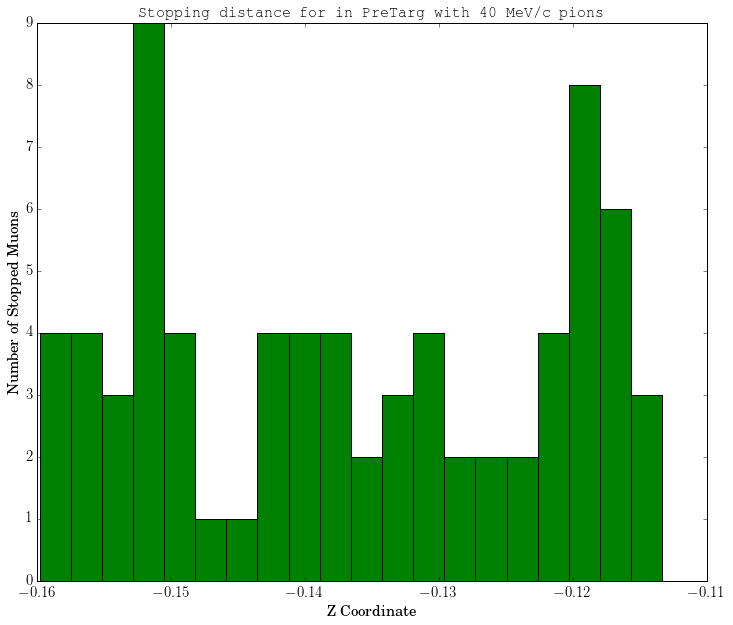

In [7]:
## Plot stopping distribution histograms
for histo in stop_z_dist:
    # Get fields back for histograms
    volume = histo.volume
    momentum = histo.momentum
    particle = histo.particle
    
    # Get data back from histograms
    data = histo.data
    bins_x = histo.bin_edges[:-1]
                
    # Make some labels
    hist_x_label="Z Coordinate"
    hist_y_label=r"Number of Stopped "+particle 
    hist_title  =r"\verb|Stopping distance for in "+volume+" with "+momentum+" MeV/c "+paricle+"|"   
    
    # Save this information somewhere
    hist_dirname = geom_dir+"/stopped_distance/"+volume
    hist_filename="stop_dist_"+pid+"_"+momentum+"MeV"+"_"+volume

    plot_1d_histogram(data, bins_x, title=hist_title,\
                      x_label=hist_x_label, y_label=hist_y_label,\
                      filename=hist_filename, dirname=hist_dirname)
    show()

In [ ]:
# 200 KeV to 6 MeV photons off target
# steps at different energies
# Measure energy diposted in Ge 

# 28-40 
# stopping distribution vs. energy spectrum in, simulating from muons
# energy spectrum with and without scintillator, pick a cut for the event in the scintillator

# tolerances 
# 5.5 beam exit flange to center TV
# 18 cm between veto and target